# Data analysis

Please make sure to have read the README of this project. To use this notebook, make sure to have downloaded the data. Use `preprocess_PPMI.ipynb` first to create a `DataLoader` class.

This notebook can be used to inspect the data in a dataloader object. One may investigate each of the 4 data components:
- [1. PPMI network](#PPMI_Network): under active development at the [Fraenkel Lab](https://github.com/fraenkel-lab)
- [2. Metabolite attributes](#Metabolite_Attributes): with data from [HMDB 4.0 download](https://hmdb.ca/downloads)
- [3. Protein attributes](#Protein_Atrributes): with data from [Protein Atlas download](https://www.proteinatlas.org/search)
- [4. Metabolite class labels](#Metabolite_Class_Labels): with data from San-Millán et al. (2020), available at [10.3389/fphys.2020.00578](https://doi.org/10.3389/fphys.2020.00578)

In [14]:
import networkx as nx
import numpy as np
import pandas as pd
import scipy
from scipy.stats import normaltest
from scipy.stats import shapiro
import matplotlib.pyplot as plt
from itertools import compress
from pathlib import Path
from matplotlib_venn import venn2

from utils.data import load_PPMI_data
import data_utils as du
from PPMI_dataloader import *

data_dir = du.find_data_dir('app')
dataloader_file = du.get_file_path(data_dir, 'class based structure', 'dataloaders', 'dataloader.p')
dataloader = du.read_from_pickle(dataloader_file)

<a id='PPMI_Network'></a>
## 1. PPMI Network

### Count number of nodes per type in PPMI networks

In [29]:
def node_types_counts(G):
    PPMI_type_mask = np.array([0 if 'HMDB' in node else 1 for node in G.nodes], dtype='int32')    
    n_nodes = len(G.nodes)
    n_metabolite_nodes = np.where(PPMI_type_mask==0, 1, 0).sum()
    n_protein_nodes = np.where(PPMI_type_mask==1, 1, 0).sum()
    return n_protein_nodes, n_metabolite_nodes, n_nodes

def compare_node_types_counts(dataloader):
    node_types_counts(dataloader.PPMI_full)
    node_types_counts(dataloader.PPMI_pruned)
    df = pd.DataFrame([node_types_counts(dataloader.PPMI_full), node_types_counts(dataloader.PPMI_pruned)], index=['Full PPMI', 'Pruned PPMI'], columns=['Proteins', 'Metabolites', 'Total']).T
    return df 

compare_node_types_counts(dataloader)

Full PPMI  Pruned PPMI
Proteins         15835        11924
Metabolites      20759          228
Total            36594        12152

### Plot degree distributions

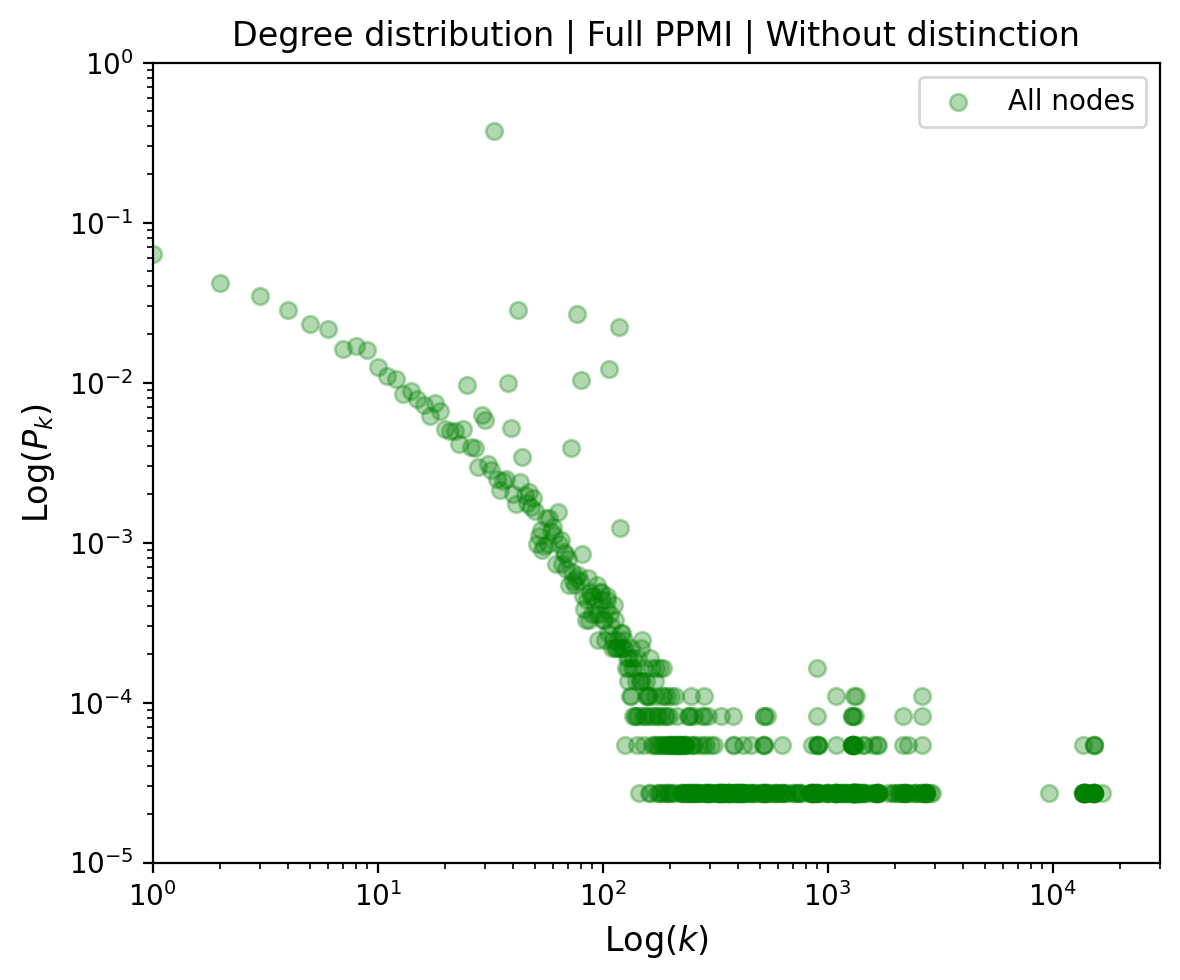

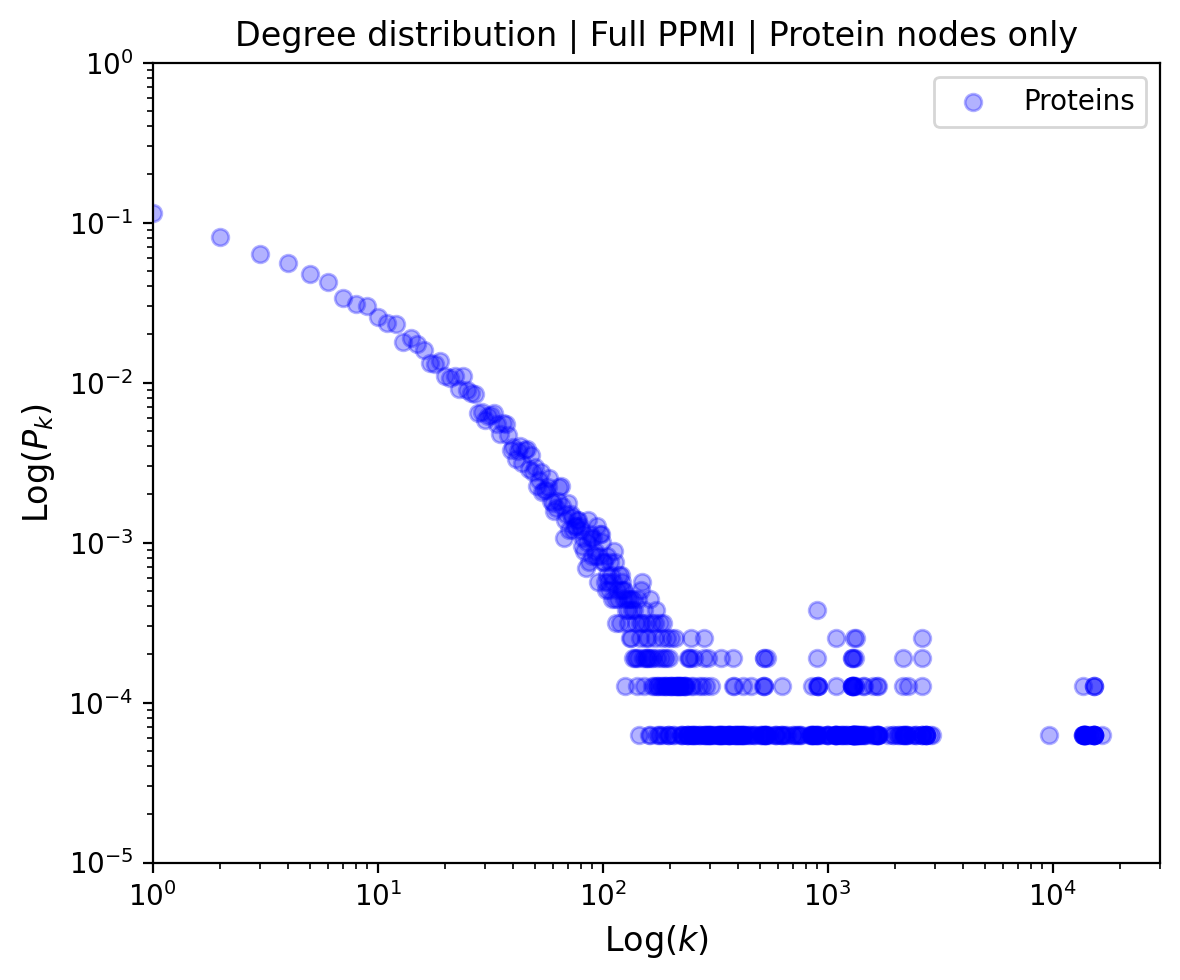

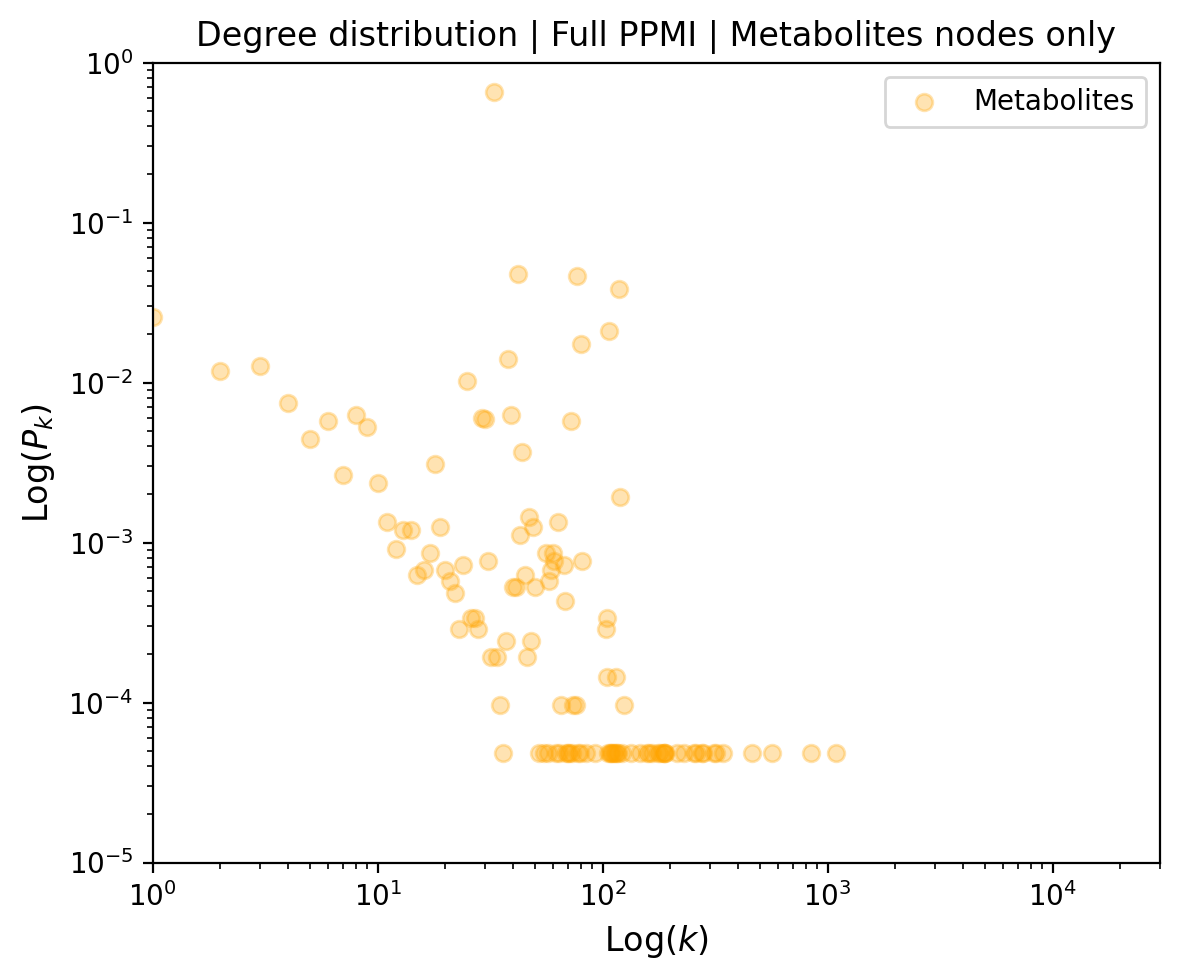

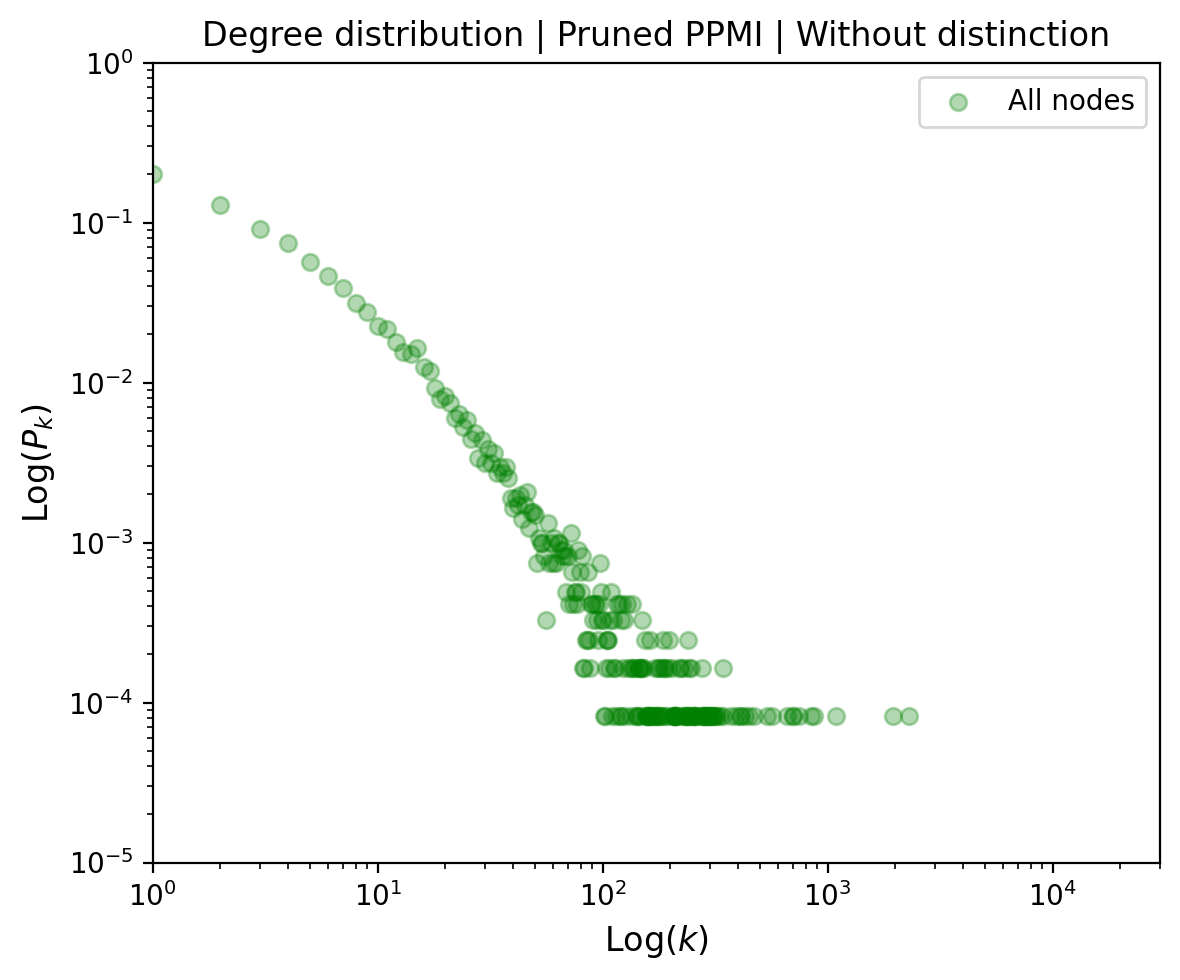

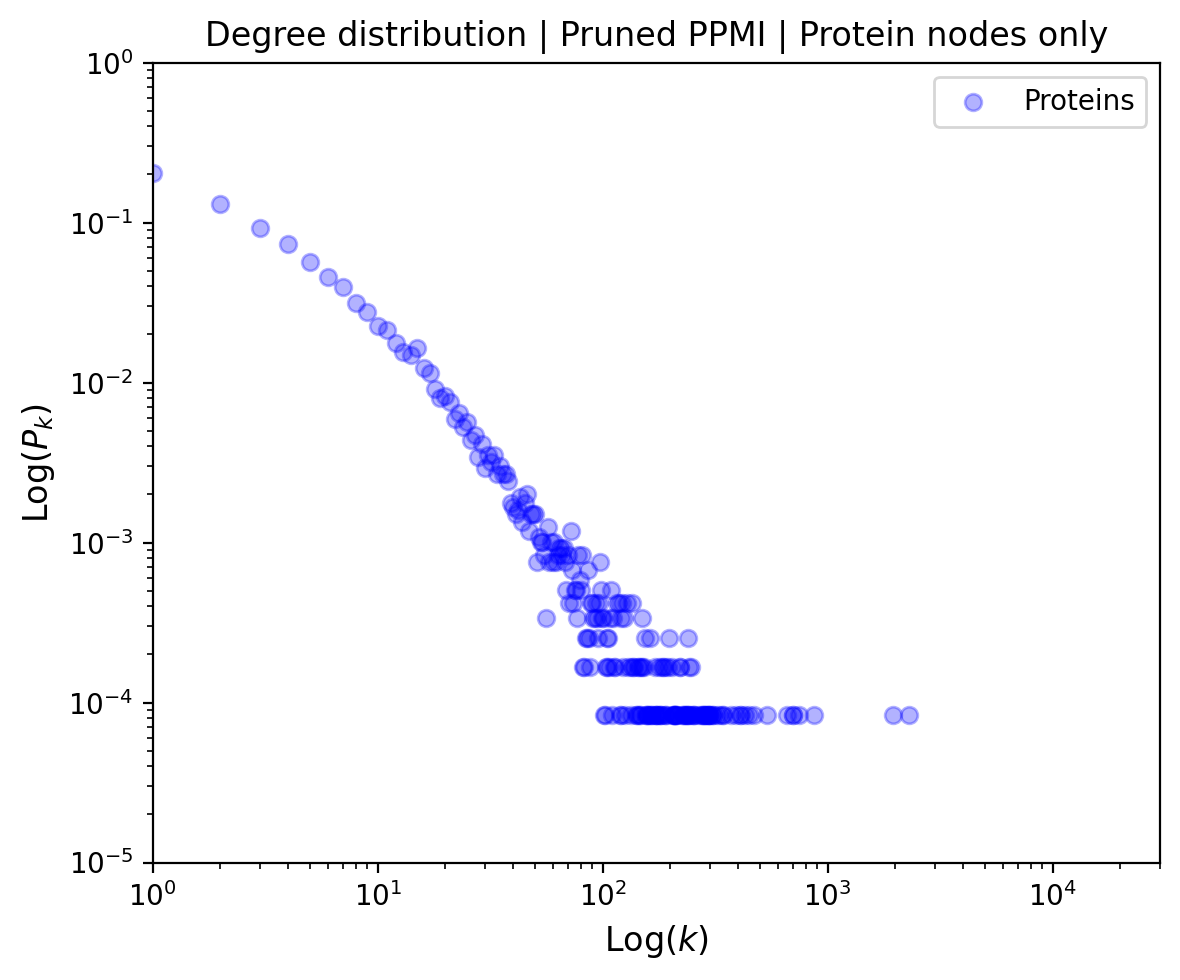

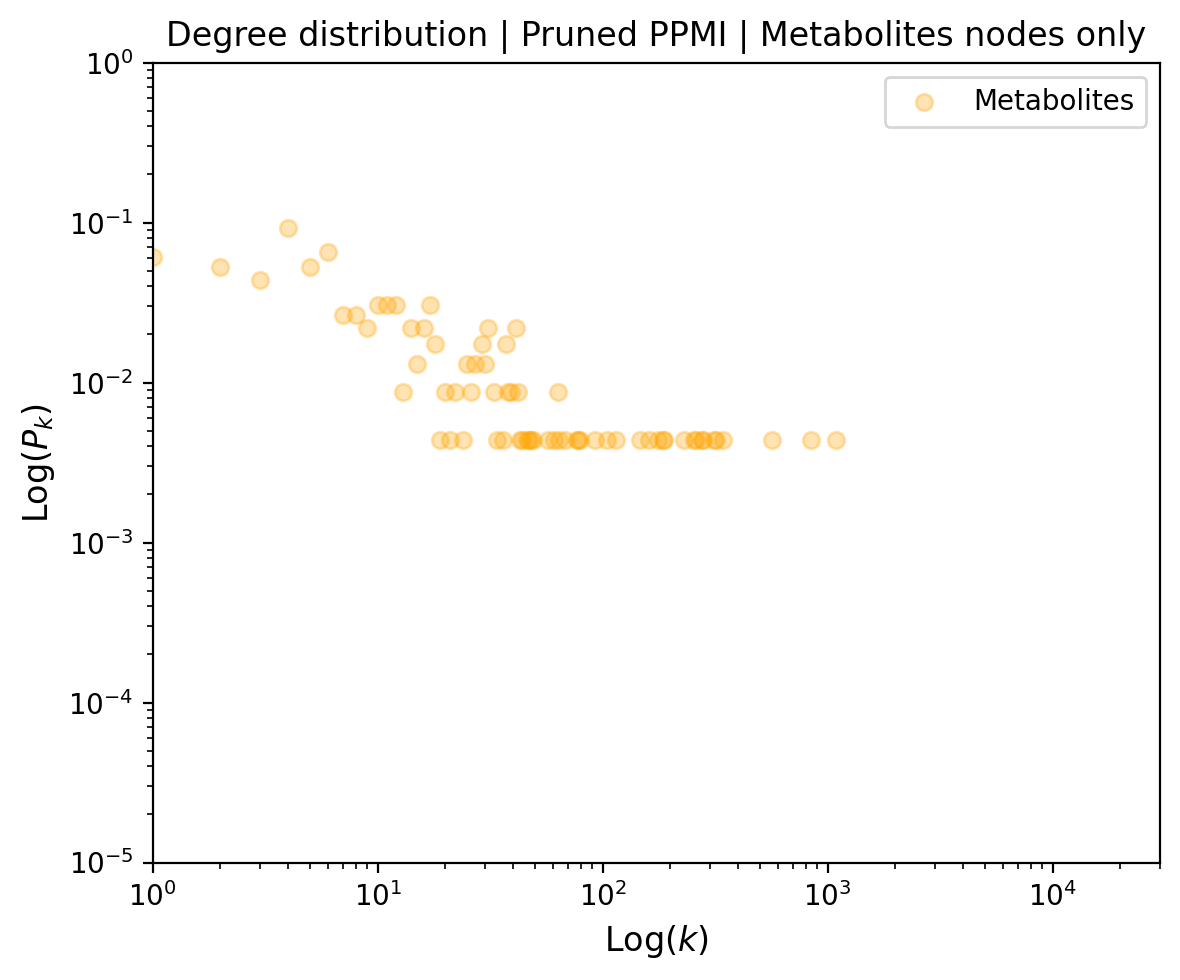

In [18]:
def plot_degree_distribution_per_nodetype(G, plot_metabolites=True, plot_proteins=True, title='', save_fig=False):
    PPMI_type_mask = np.array([0 if 'HMDB' in node else 1 for node in G.nodes], dtype='int32')
    
    n_nodes = len(G.nodes)
    n_metabolite_nodes = np.where(PPMI_type_mask==0, 1, 0).sum()
    n_protein_nodes = np.where(PPMI_type_mask==1, 1, 0).sum()

    nodes, degree_count = zip(*list(G.degree))
    degree_value_counts = pd.Series(degree_count, index=nodes).value_counts()
    P_k = degree_value_counts/n_nodes
    
    metabolite_nodes, metabolite_degree_count = zip(*list(compress(list(G.degree), list(PPMI_type_mask == [0]*n_nodes))))
    protein_nodes, protein_degree_count = zip(*list(compress(list(G.degree), list(PPMI_type_mask == [1]*n_nodes))))

    metabolite_degree_value_counts = pd.Series(metabolite_degree_count, index=metabolite_nodes).value_counts()
    metabolite_P_k = metabolite_degree_value_counts/n_metabolite_nodes

    protein_degree_value_counts = pd.Series(protein_degree_count, index=protein_nodes).value_counts()
    protein_P_k = protein_degree_value_counts/n_protein_nodes  

    alpha=.3
    fig = plt.figure(figsize=(6,5), dpi=200)
    fig.patch.set_facecolor('white')    

    plt.ylim([10**(-5), 10**(0)])    

    plt.yscale('log')
    plt.xscale('log')    

    plt.xlim([1, 30000])
    
    if plot_proteins and plot_metabolites:
        plt.scatter(P_k.index, P_k, color='green', alpha=alpha, label='All nodes')
    else:
        if plot_proteins:
            plt.scatter(protein_P_k.index, protein_P_k, color='blue', alpha=alpha, label='Proteins')
        if plot_metabolites:
            plt.scatter(metabolite_P_k.index, metabolite_P_k, color='orange', alpha=alpha, label='Metabolites')
    
    fontsize_labels=12
    pk_explanation_str = '   ($P_k$=probability)'
    k_explanation_str = '   ($k$=degree)'
    plt.xlabel('Log($k$)', fontsize=fontsize_labels)
    plt.ylabel('Log($P_k$)', fontsize=fontsize_labels)
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    if save_fig:
        filename = title.replace(' | ', '--') + '.png'
        plt.savefig(Path('figures', filename))
    plt.show()

general_title = 'Degree distribution'    
graph_name = 'Full PPMI'
plot_degree_distribution_per_nodetype(dataloader.PPMI_full, title=f'{general_title} | {graph_name} | Without distinction', save_fig=True)
plot_degree_distribution_per_nodetype(dataloader.PPMI_full, plot_metabolites=False, title=f'{general_title} | {graph_name} | Protein nodes only', save_fig=True)
plot_degree_distribution_per_nodetype(dataloader.PPMI_full, plot_proteins=False, title=f'{general_title} | {graph_name} | Metabolites nodes only', save_fig=True)

graph_name = 'Pruned PPMI'
plot_degree_distribution_per_nodetype(dataloader.PPMI_pruned, title=f'{general_title} | {graph_name} | Without distinction', save_fig=True)
plot_degree_distribution_per_nodetype(dataloader.PPMI_pruned, plot_metabolites=False, title=f'{general_title} | {graph_name} | Protein nodes only', save_fig=True)
plot_degree_distribution_per_nodetype(dataloader.PPMI_pruned, plot_proteins=False, title=f'{general_title} | {graph_name} | Metabolites nodes only', save_fig=True)

### Inspect metapath instances

In [32]:
adjlists, edge_metapath_indices_list, features_list, adjM, type_mask, labels, train_val_test_idx = load_PPMI_data()

In [33]:
def get_metapath_neighbor_count(metapath_id=0):
    n_nodes = len(edge_metapath_indices_list[metapath_id])
    metapath_neighbor_count = scipy.sparse.csr_matrix((n_nodes, n_nodes), dtype=float)
    for source, metapath_instances in edge_metapath_indices_list[metapath_id].items():
        metapath_neighbors, path_instance_counts = np.unique(metapath_instances[:,0], return_counts=True)
        source_target_count = list(zip([source]*len(metapath_neighbors), metapath_neighbors, path_instance_counts))

        for source, target, count in source_target_count:
            metapath_neighbor_count[source, target] = count
    return metapath_neighbor_count

MPM_neighbor_count = get_metapath_neighbor_count(0)
MPPM_neighbor_count = get_metapath_neighbor_count(1)

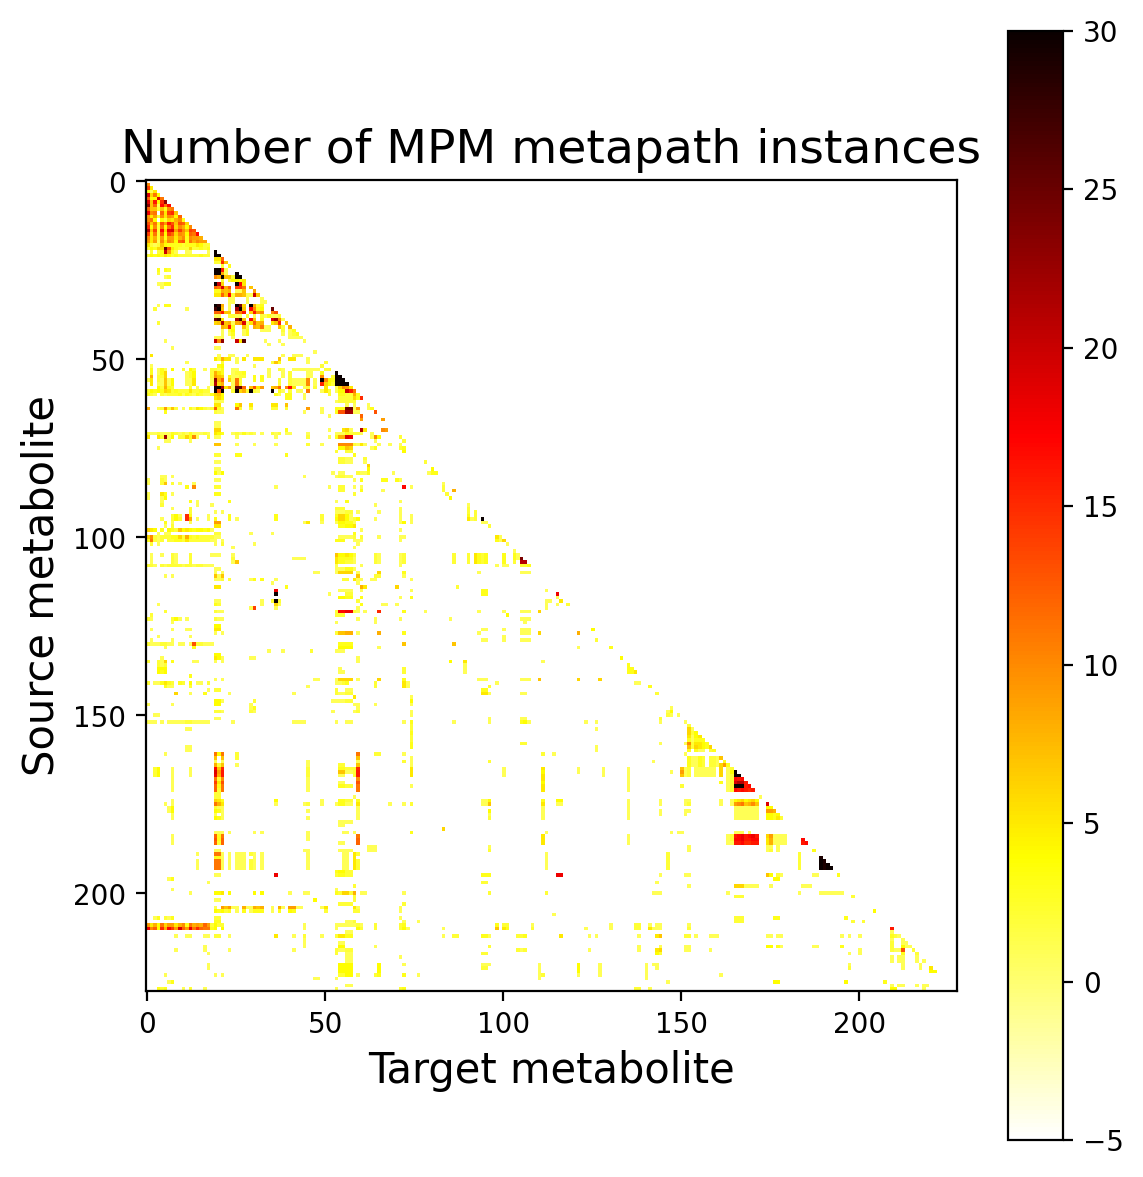

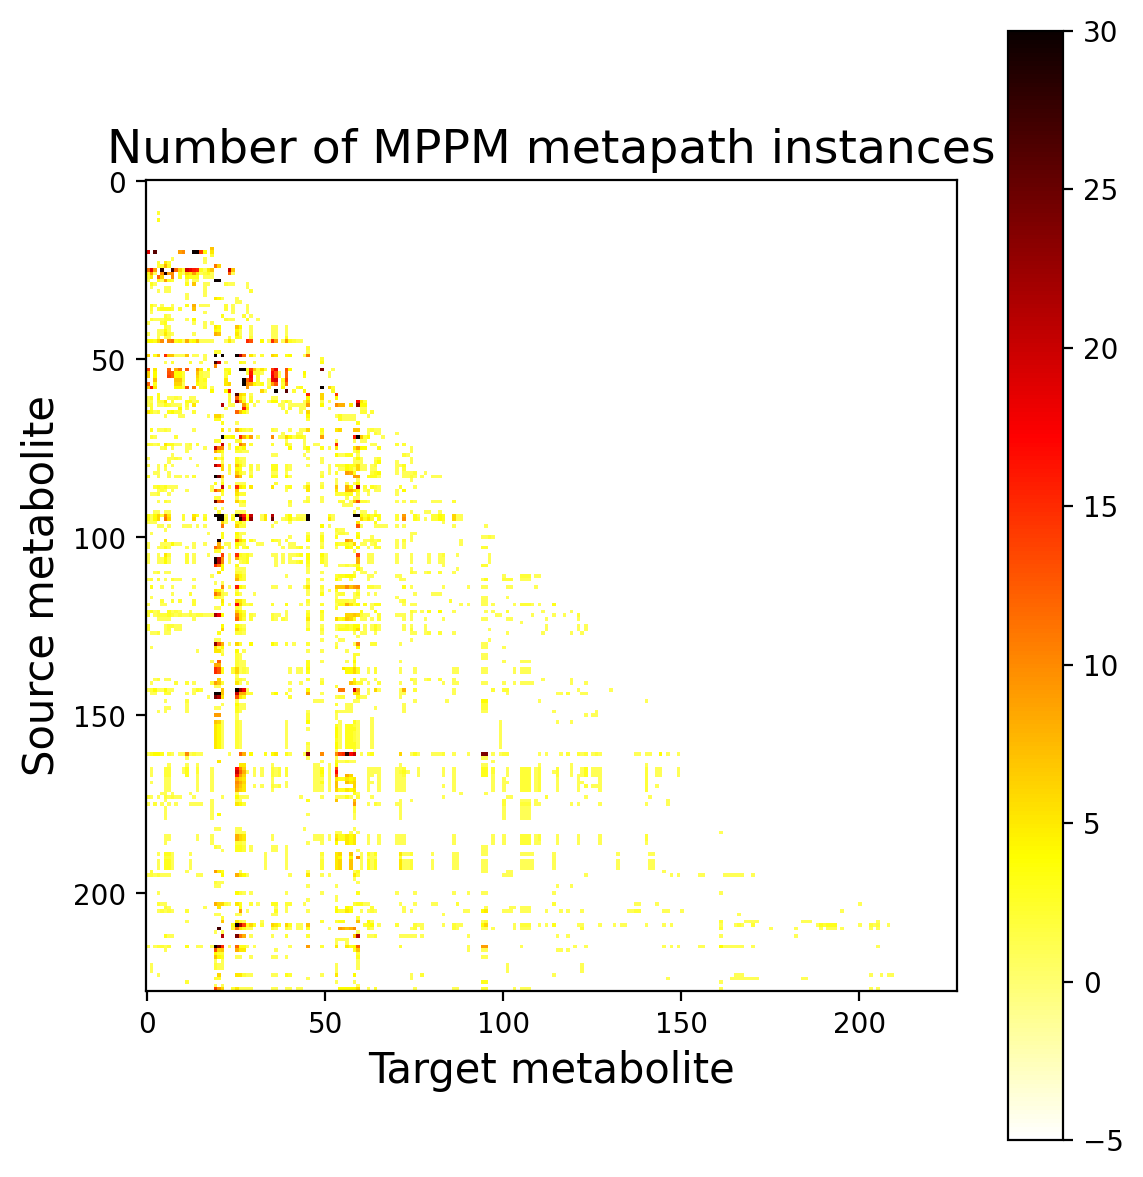

In [46]:
def plot_heatmap_metapath_neighbor_count(sparse_matrix, metapath, save_fig=False):
    max_neighborcount = 30
    zero_value = -5

    sparse_matrix = scipy.sparse.tril(sparse_matrix, format='csr')
    sparse_matrix[sparse_matrix > max_neighborcount] = max_neighborcount
    sparse_matrix[sparse_matrix == 0] = zero_value


    fig = plt.figure(figsize=(6,6), dpi=200)
    fig.patch.set_facecolor('white')    
    d=sparse_matrix.todense()
    plt.imshow(d,interpolation='none',cmap='hot_r')
    plt.ylabel('Source metabolite', fontsize=15)
    plt.xlabel('Target metabolite', fontsize=15)
    plt.colorbar()
    title=f'Number of {metapath} metapath instances'
    plt.title(title, fontsize=17)
    plt.tight_layout()
    if save_fig:
        filename = title + '.png'
        plt.savefig(Path('figures', filename))
    plt.show()

plot_heatmap_metapath_neighbor_count(MPM_neighbor_count, 'MPM', save_fig=True)
plot_heatmap_metapath_neighbor_count(MPPM_neighbor_count, 'MPPM', save_fig=True)

### Inspecting outliers with many metapath instances

In [67]:
def get_outliers(sparse_matrix, max_neighborcount, dataloader):
    outliers_matrix = scipy.sparse.tril(sparse_matrix, format='csr')
    outliers_matrix[sparse_matrix < max_neighborcount] = 0
    sources, targets, counts = scipy.sparse.find(outliers_matrix)

    HMDB_ids = dataloader.y.index

    df = pd.DataFrame(list(zip(HMDB_ids[sources], HMDB_ids[targets], counts)), columns=['Source', 'Target', 'MPM count'])
    df = df.sort_values('MPM count', ascending=False).reset_index(drop=True).astype({'MPM count': int})
    return df 

print(get_outliers(MPM_neighbor_count, 30, dataloader))

         Source       Target  MPM count
0   HMDB0001341  HMDB0000538        824
1   HMDB0000250  HMDB0000538        256
2   HMDB0001487  HMDB0000902        250
3   HMDB0000217  HMDB0000221        243
4   HMDB0000045  HMDB0000538        219
5   HMDB0000250  HMDB0000045        199
6   HMDB0001201  HMDB0001273        197
7   HMDB0001397  HMDB0001273        145
8   HMDB0001397  HMDB0001201        142
9   HMDB0000902  HMDB0000217        132
10  HMDB0001185  HMDB0000939        115
11  HMDB0001429  HMDB0000538        112
12  HMDB0001429  HMDB0001341        111
13  HMDB0001487  HMDB0000217        108
14  HMDB0000902  HMDB0000221        104
15  HMDB0001487  HMDB0000221         99
16  HMDB0001273  HMDB0000538         88
17  HMDB0000902  HMDB0001248         84
18  HMDB0000827  HMDB0000220         76
19  HMDB0000220  HMDB0000806         76
20  HMDB0000827  HMDB0000806         75
21  HMDB0001487  HMDB0001248         75
22  HMDB0000250  HMDB0001273         64
23  HMDB0000285  HMDB0000538         61


### Creating Venn diagrams of protein connections

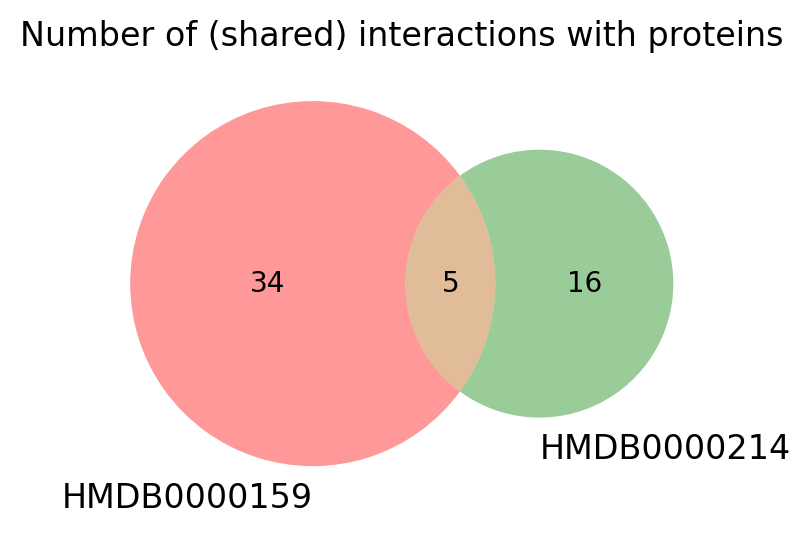

hmdb_accession
HMDB0000159    0
HMDB0000214    0
Name: CCS, dtype: object

In [66]:
def plot_venn_protein_links(metabolite_A, metabolite_B, save_fig=False):
    set_a = set(list(dataloader.PPMI_pruned[metabolite_A]))
    set_b = set(list(dataloader.PPMI_pruned[metabolite_B]))

    # Second way
    fig = plt.figure(figsize=(4,3.2), dpi=200)
    fig.patch.set_facecolor('white')    
    v = venn2([set_a, set_b], set_labels = (metabolite_A, metabolite_B))
    title = 'Number of (shared) interactions with proteins'
    plt.title(title)
    if save_fig:
        filename = title + '--' + metabolite_A + '-' + metabolite_B + '.png'
        plt.savefig(Path('figures', filename))
    plt.show()

def get_matapath_based_neighbors(dataloader, target_node_name, metapath_index=0):
    target_node_index = list(dataloader.y.index).index(target_node_name)
    metapaths_inspect = edge_metapath_indices_list[metapath_index][target_node_index]
    metapath_based_neighbors = pd.Series(metapaths_inspect[:, 0]).value_counts()
    metapath_based_neighbors.index = dataloader.y.index[np.array(metapath_based_neighbors.index)]
    name = f'{dataloader.y.index[target_node_index]}_metapath_{metapath_index}_based_neighbours'
    metapath_based_neighbors.name = name
    return metapath_based_neighbors


metabolite_1 = 'HMDB0000159'
metabolite_2 = 'HMDB0000214'
plot_venn_protein_links(metabolite_1, metabolite_2, save_fig=True)
dataloader.y[[metabolite_1, metabolite_2]]

In [13]:
dataloader.X.shape, dataloader.protein_features.shape

((228, 253), (11924, 321))

<a id='Metabolite_Attributes'></a>
## 2. X matrix (metabolite properties)

In [72]:
dataloader.X

state=="Solid"  state=="Liquid"  \
hmdb_accession                                    
HMDB0000161                  1                0   
HMDB0000517                  1                0   
HMDB0000168                  1                0   
HMDB0000191                  1                0   
HMDB0000574                  1                0   
...                        ...              ...   
HMDB0000060                  1                0   
HMDB0000152                  1                0   
HMDB0000735                  1                0   
HMDB0002035                  1                0   
HMDB0000707                  1                0   

                super_class=="Organic acids and derivatives"  \
hmdb_accession                                                 
HMDB0000161                                                1   
HMDB0000517                                                1   
HMDB0000168                                                1   
HMDB0000191                                                1   
HMDB0000574                                                1   
...                                                      ...   
HMDB0000060                                                1   
HMDB0000152                                                0   
HMDB0000735                                                1   
HMDB0002035                                                0   
HMDB0000707                                                0   

                super_class=="Organic nitrogen compounds"  \
hmdb_accession                                              
HMDB0000161                                             0   
HMDB0000517                                             0   
HMDB0000168                                             0   
HMDB0000191                                             0   
HMDB0000574                                             0   
...                                                   ...   
HMDB0000060                                             0   
HMDB0000152                                             0   
HMDB0000735                                             0   
HMDB0002035                                             0   
HMDB0000707                                             0   

                super_class=="Lipids and lipid-like molecules"  \
hmdb_accession                                                   
HMDB0000161                                                  0   
HMDB0000517                                                  0   
HMDB0000168                                                  0   
HMDB0000191                                                  0   
HMDB0000574                                                  0   
...                                                        ...   
HMDB0000060                                                  0   
HMDB0000152                                                  0   
HMDB0000735                                                  0   
HMDB0002035                                                  0   
HMDB0000707                                                  0   

                super_class=="Nucleosides, nucleotides, and analogues"  \
hmdb_accession                                                           
HMDB0000161                                                     0        
HMDB0000517                                                     0        
HMDB0000168                                                     0        
HMDB0000191                                                     0        
HMDB0000574                                                     0        
...                                                           ...        
HMDB0000060                                                     0        
HMDB0000152                                                     0        
HMDB0000735                                                     0        
HMDB0002035                                         

### Investigating feature value distributions

In [8]:
def create_feature_distribution_df(dataloader, feature_name):
    target_distribution_stats = dataloader.target_distribution_stats()
    df = pd.DataFrame(pd.DataFrame([dataloader.X[feature_name], dataloader.y]).T.value_counts(), columns=['CCS_value_amount']).reset_index()
    df2 = df.loc[:,[feature_name, 'CCS_value_amount']]
    df2 = df2.set_index(feature_name)
    df3 = df2.groupby(df2.index).sum()
    df['feature_value_amount'] = df3['CCS_value_amount'][df[feature_name]].reset_index(drop=True)
    df['value_percentage'] = df['CCS_value_amount'] / df['feature_value_amount'] * 100
    df['original_percentage'] = target_distribution_stats.data.loc[df['CCS']]['Percentage'].reset_index(drop=True)
    df = df.sort_values([feature_name, 'CCS'], ascending=False)
    df['diff_percentage'] = df['value_percentage'] - df['original_percentage']
    df = df.reset_index(drop=True)
    df = df.set_index([feature_name, 'CCS'])
    # cols_to_move = [feature_name, 'feature_value_amount']
    # df           = df[ cols_to_move + [ col for col in df.columns if col not in cols_to_move ] ]
    
    return df.style.format({"value_percentage": "{:.1f}%", "original_percentage": "{:.1f}%",  "diff_percentage": "{:.1f}%"}), df.loc[1, 'value_percentage'], df.loc[1,'original_percentage']

# display(create_feature_distribution_df(dataloader, 'state=="Solid"'))

value_percentages = pd.DataFrame([], columns=[1, 0, -1])

for feature_name in list(dataloader.X.columns)[2:]:
    df_i, value_percentage_i, original_percentage = create_feature_distribution_df(dataloader, feature_name)
    value_percentage_i.name = feature_name
    value_percentages = value_percentages.append(value_percentage_i)
#     display(df_i)
value_percentages

1          0  \
super_class=="Organic acids and derivatives"        27.848101  29.113924   
super_class=="Organic nitrogen compounds"           16.666667  33.333333   
super_class=="Lipids and lipid-like molecules"      52.380952  33.333333   
super_class=="Nucleosides, nucleotides, and ana...   5.882353  32.352941   
super_class=="Organoheterocyclic compounds"         34.615385  30.769231   
...                                                       ...        ...   
"Prostate" in tissue_locations                      27.272727  32.323232   
"Adrenal Medulla" in tissue_locations               20.000000  40.000000   
"Epidermis" in tissue_locations                     27.419355  37.096774   
"Spleen" in tissue_locations                        25.806452  51.612903   
"Bladder" in tissue_locations                       20.000000  44.000000   

                                                           -1  
super_class=="Organic acids and derivatives"        43.037975  
super_class=="Organic nitrogen compounds"           50.000000  
super_class=="Lipids and lipid-like molecules"      14.285714  
super_class=="Nucleosides, nucleotides, and ana...  61.764706  
super_class=="Organoheterocyclic compounds"         34.615385  
...                                                       ...  
"Prostate" in tissue_locations                      40.404040  
"Adrenal Medulla" in tissue_locations               40.000000  
"Epidermis" in tissue_locations                     35.483871  
"Spleen" in tissue_locations                        22.580645  
"Bladder" in tissue_locations                       36.000000  

[251 rows x 3 columns]

In [9]:
display_dfs = False
value_percentages_dfs = {}
for feature_name, included in dataloader.include_feature_category['metabolite'].items():
    if included and feature_name not in ['molecular_weight']:
        col_names = list(dataloader.X.columns[[feature_name+'==' in col_name for col_name in dataloader.X.columns]]) + list(dataloader.X.columns[['in ' + feature_name in col_name for col_name in dataloader.X.columns]])
        value_percentages = pd.DataFrame([], columns=[1, 0, -1])
        for col_name in col_names:
            df_i, value_percentage_i, original_percentage = create_feature_distribution_df(dataloader, col_name)
            name = col_name.replace(' in ' + feature_name, '').replace(feature_name + '==', '')
            name = name[1:-1]
            name = f'{name: >80}'
            value_percentage_i.name = name
            if value_percentages.shape[0] == 0:
                original_percentage.name = f'{"Overall distribution": >80}'
                value_percentages = value_percentages.append(original_percentage)
            value_percentages = value_percentages.append(value_percentage_i)
            if display_dfs:
                display(df_i)
        if value_percentages.shape[0] >= 2:
            value_percentages_dfs[feature_name] = value_percentages.fillna(0)

3 bars


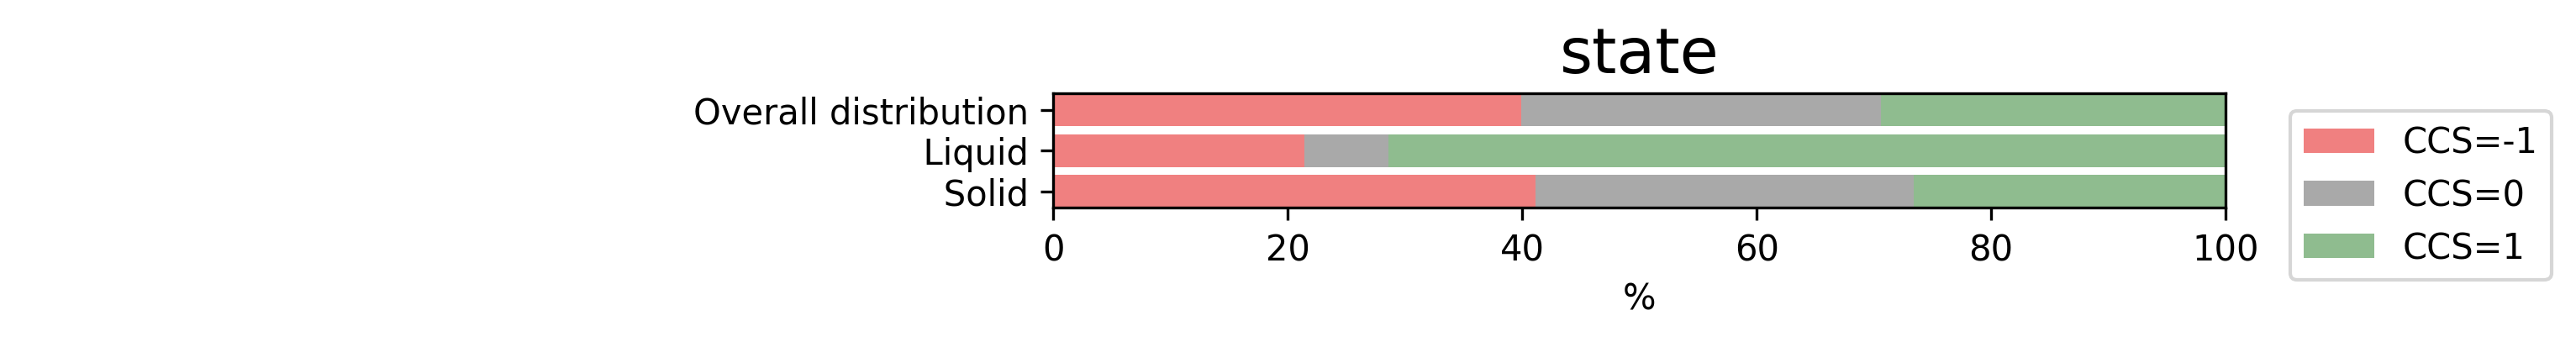

8 bars


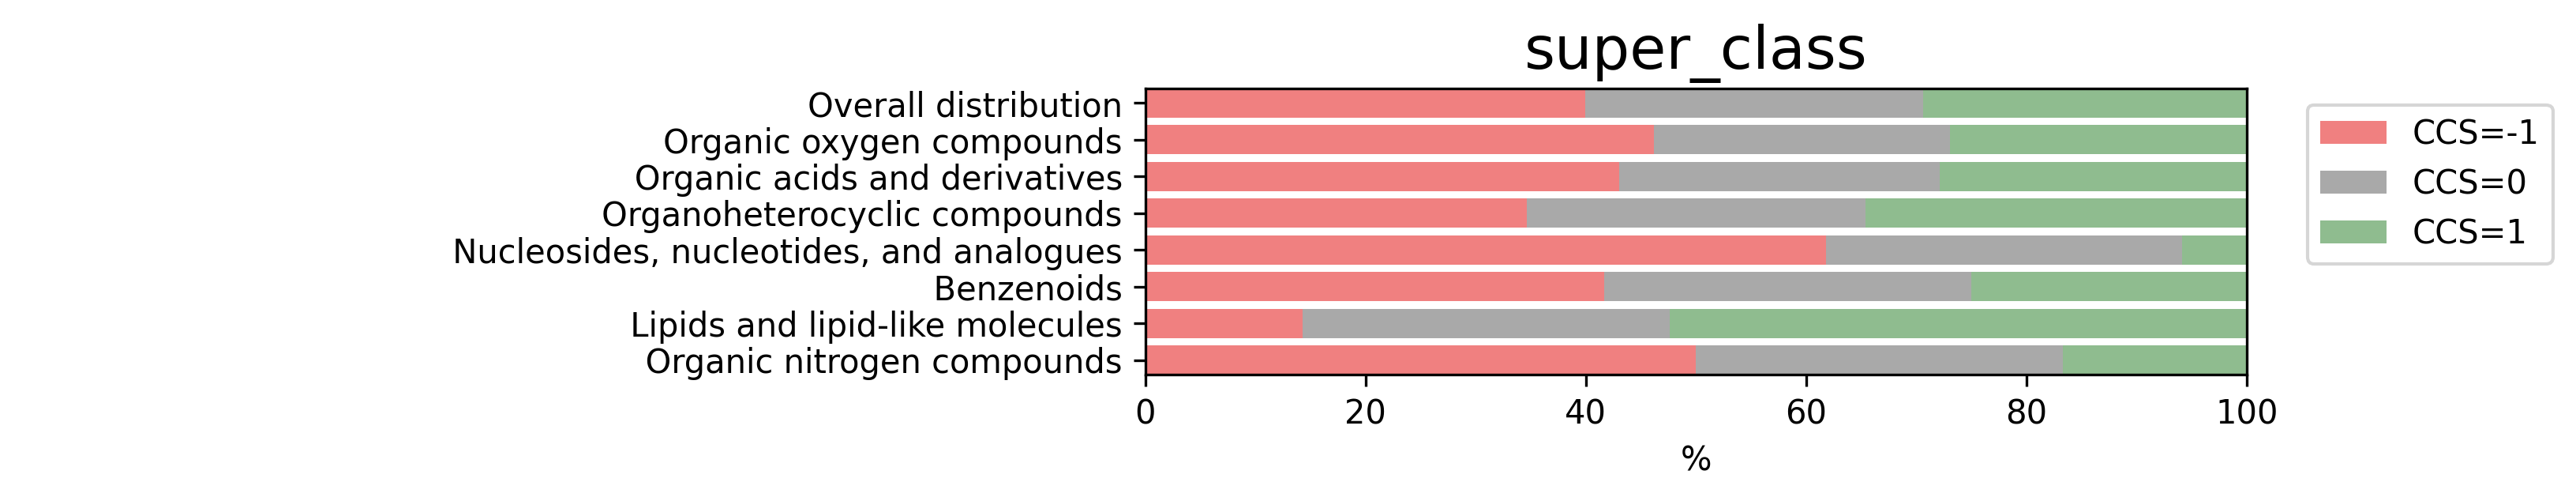

7 bars


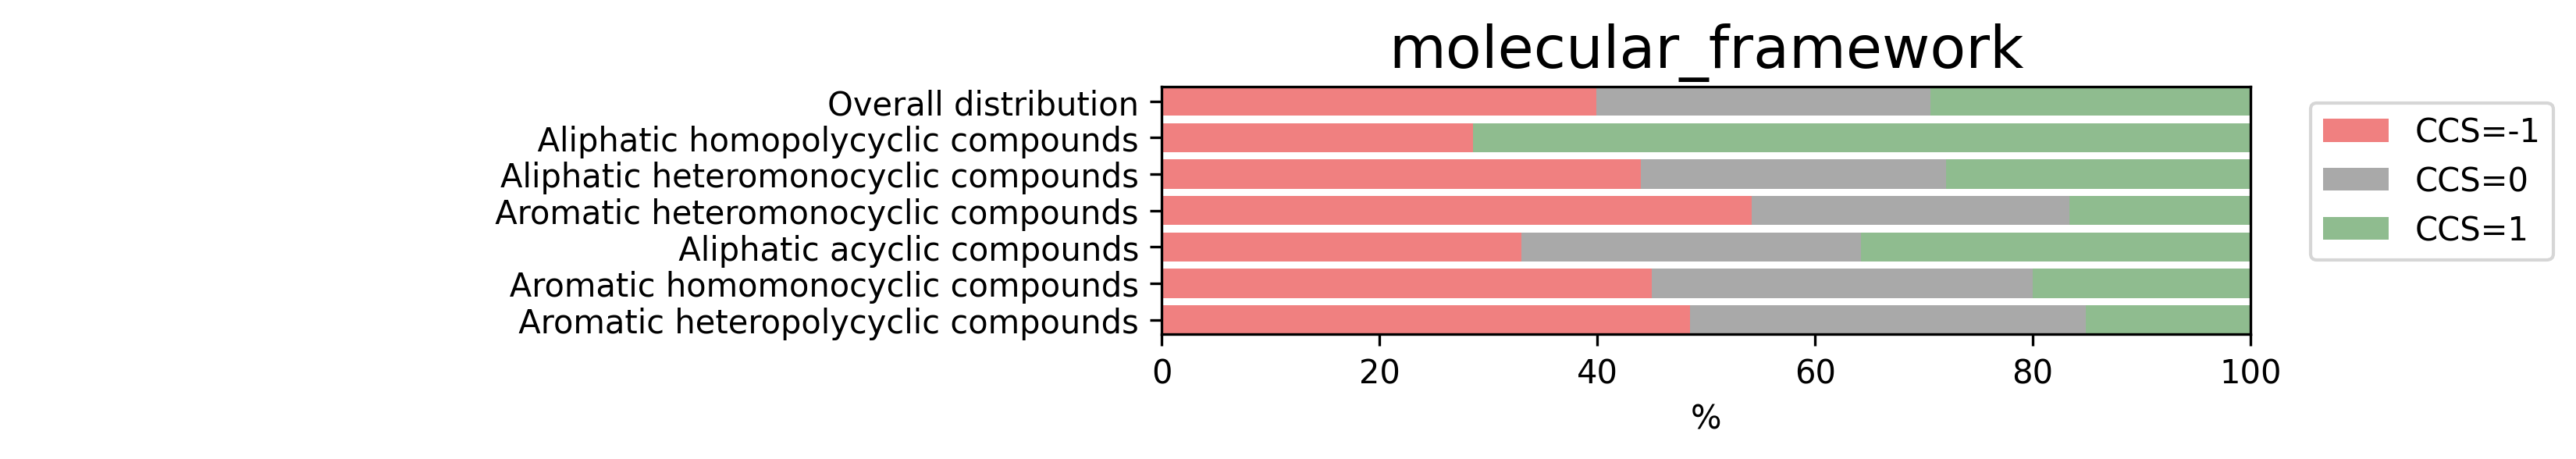

75 bars


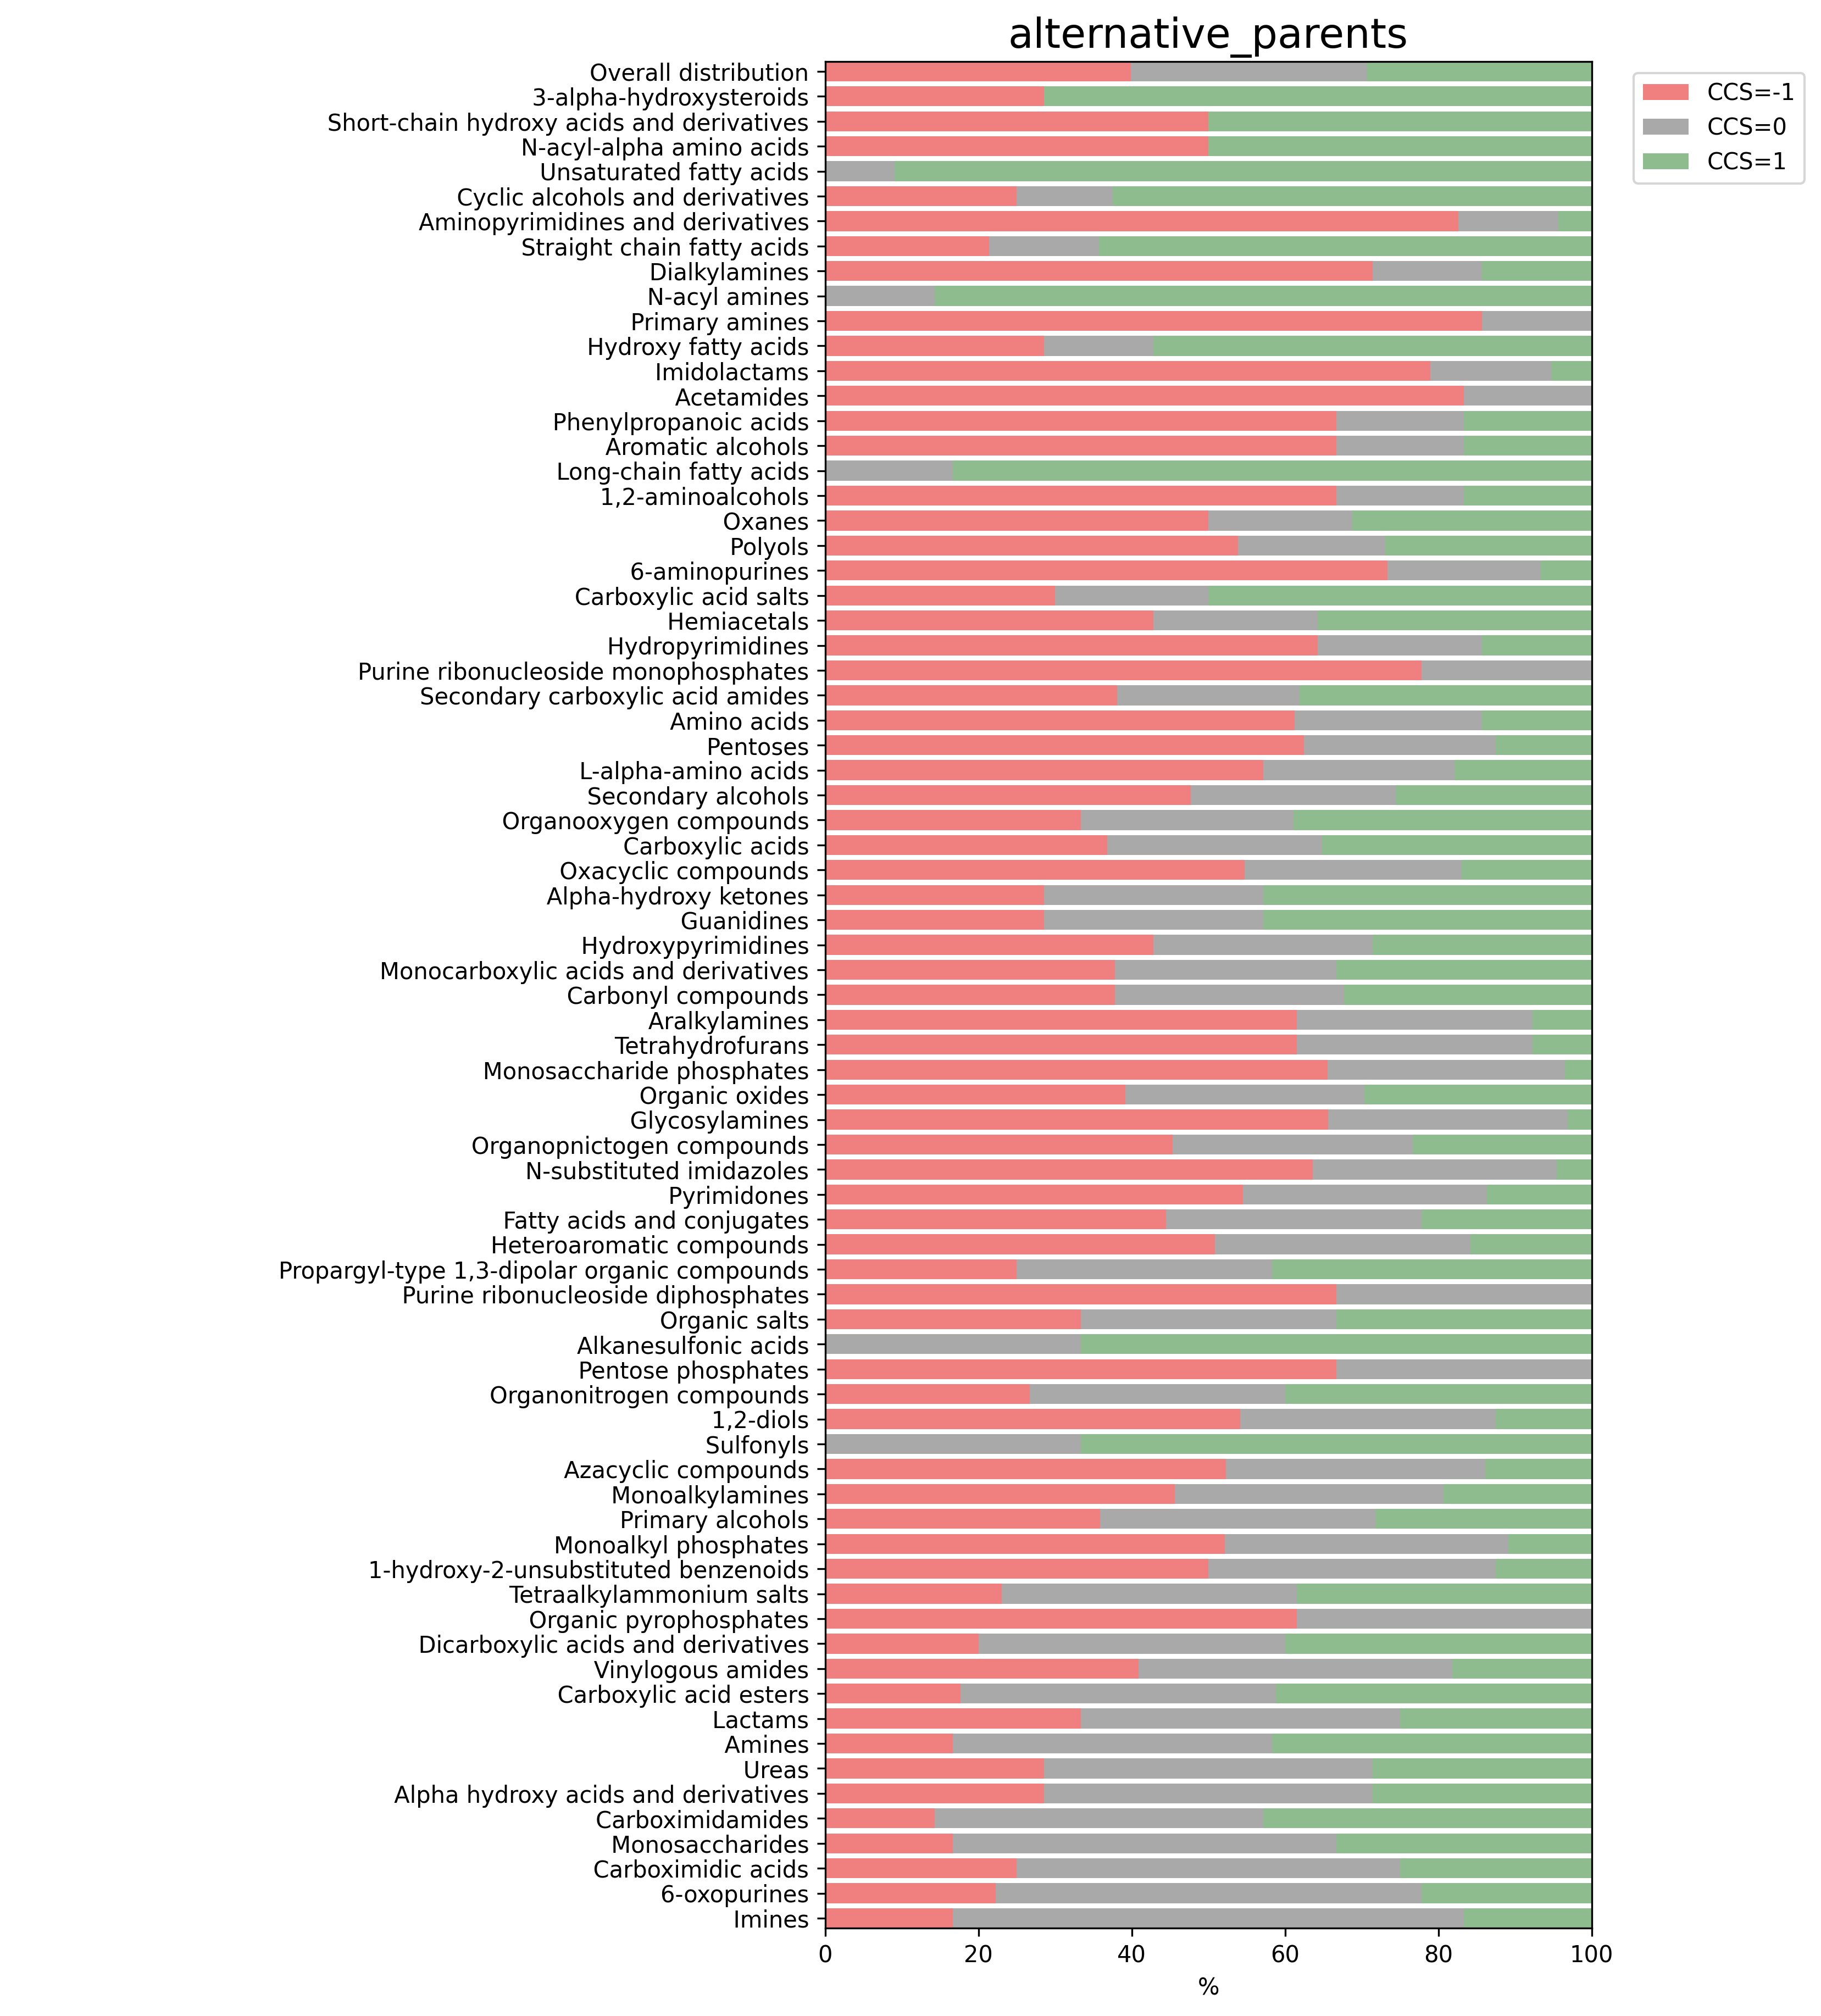

123 bars


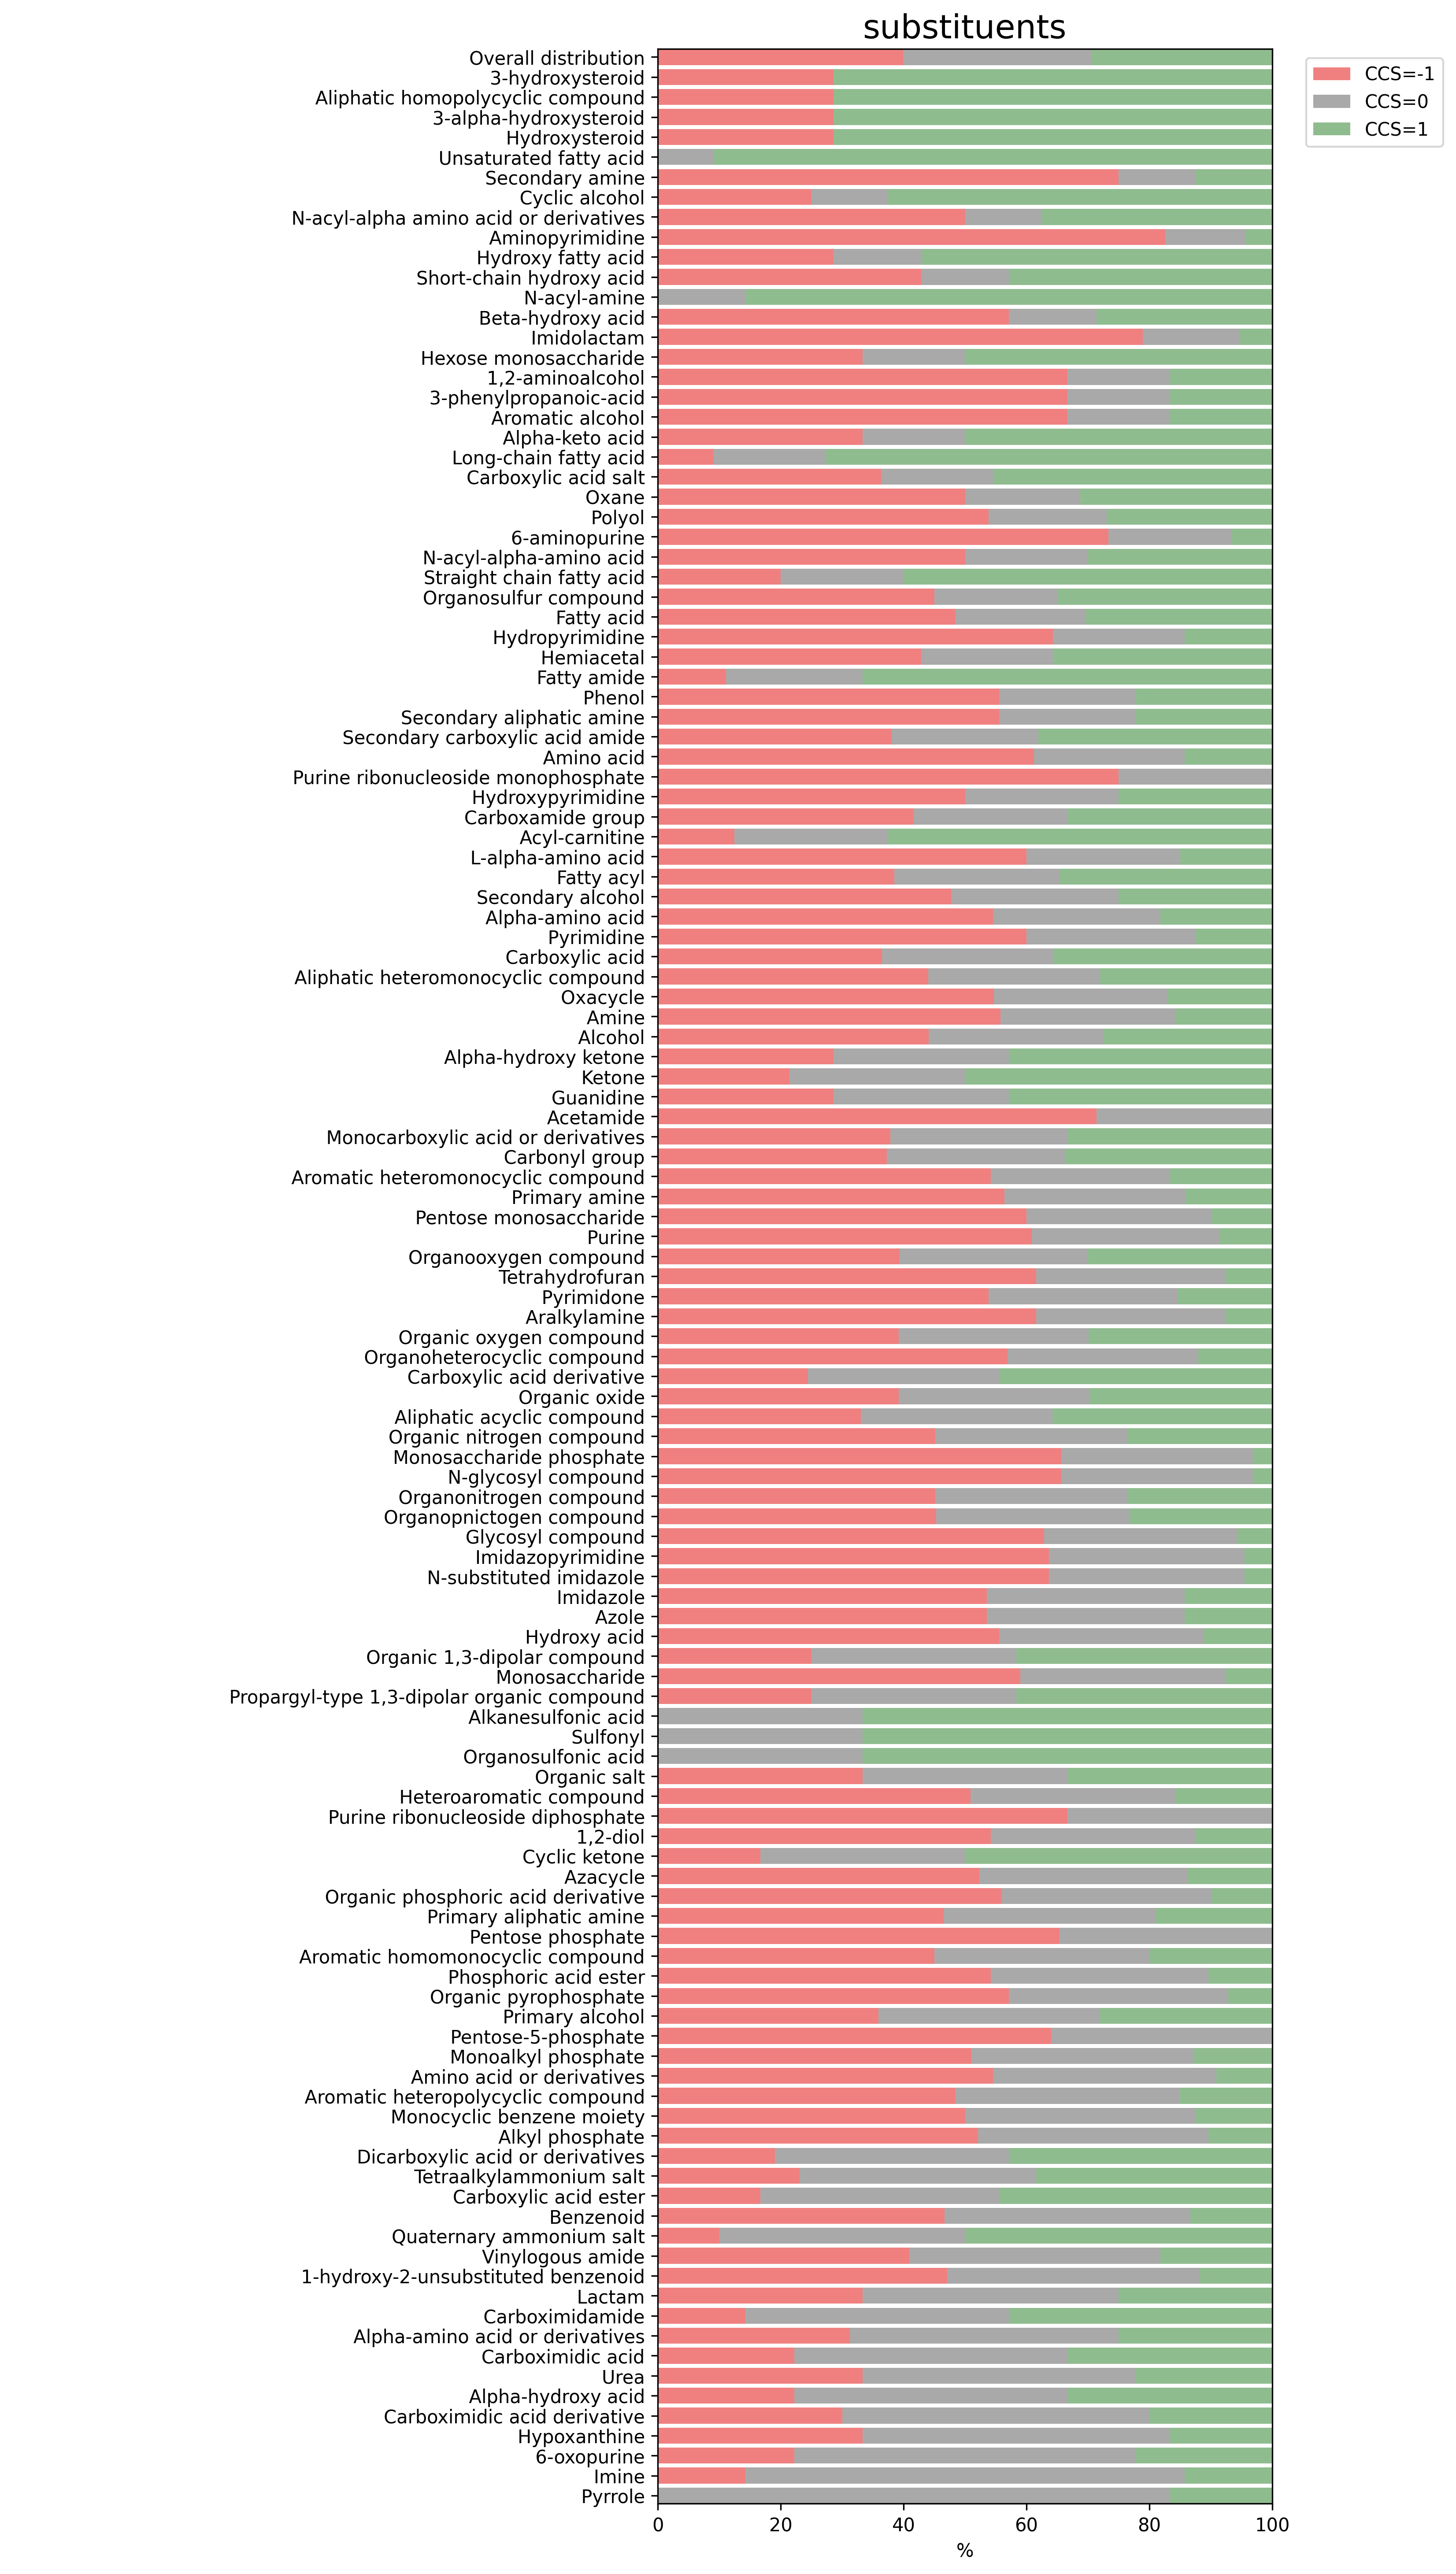

10 bars


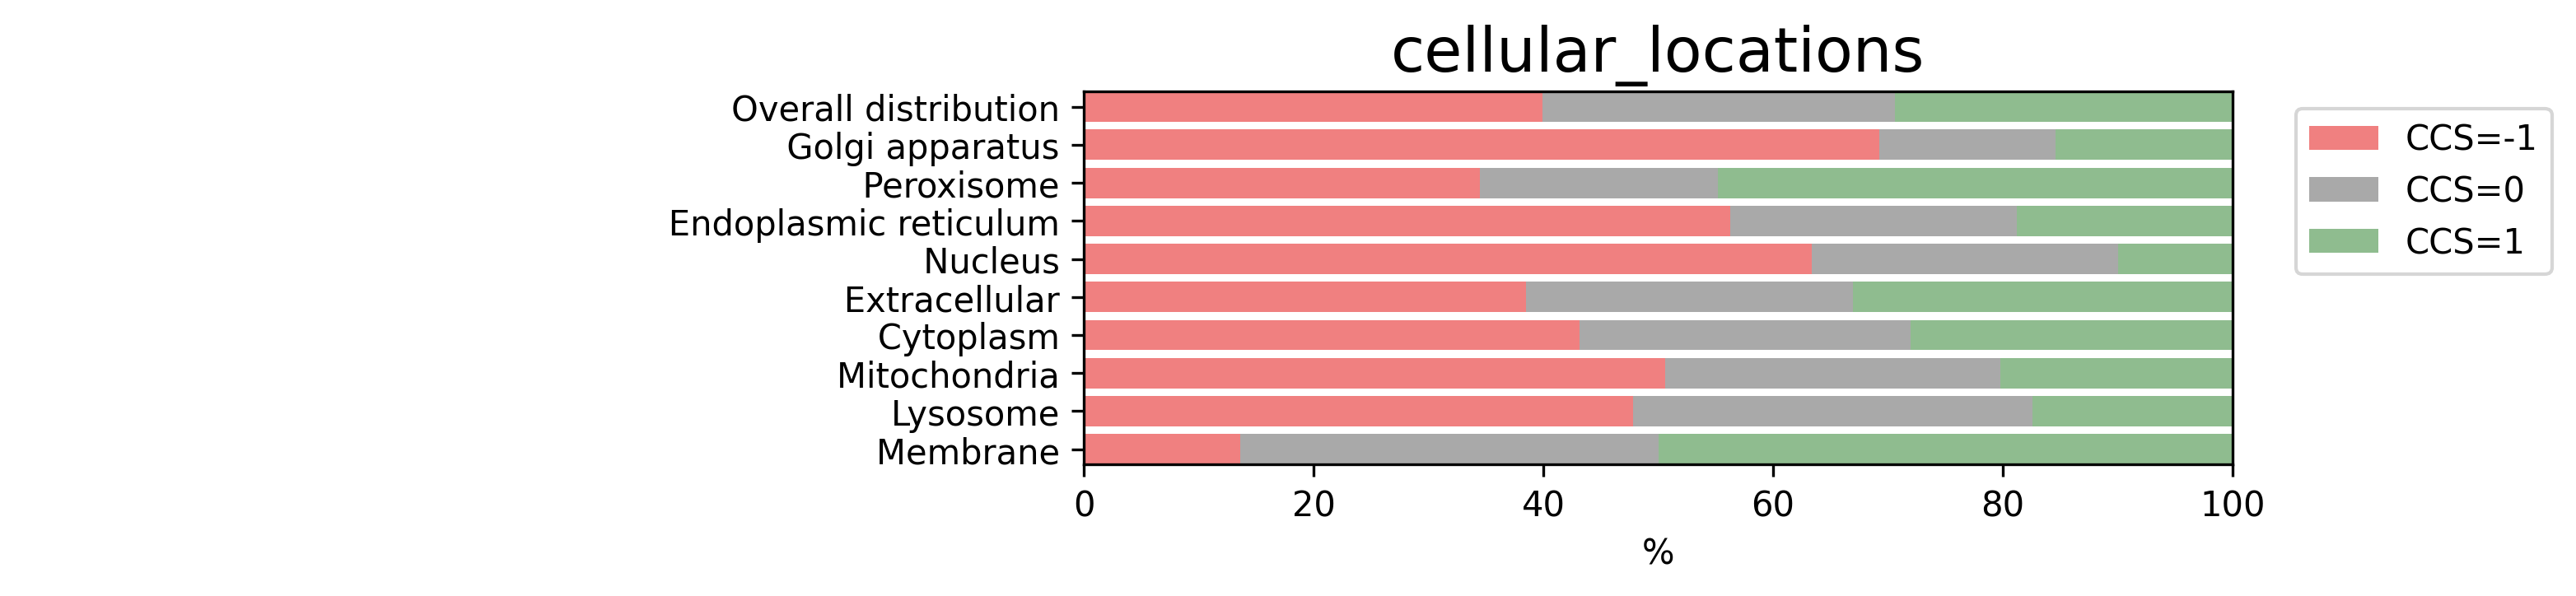

10 bars


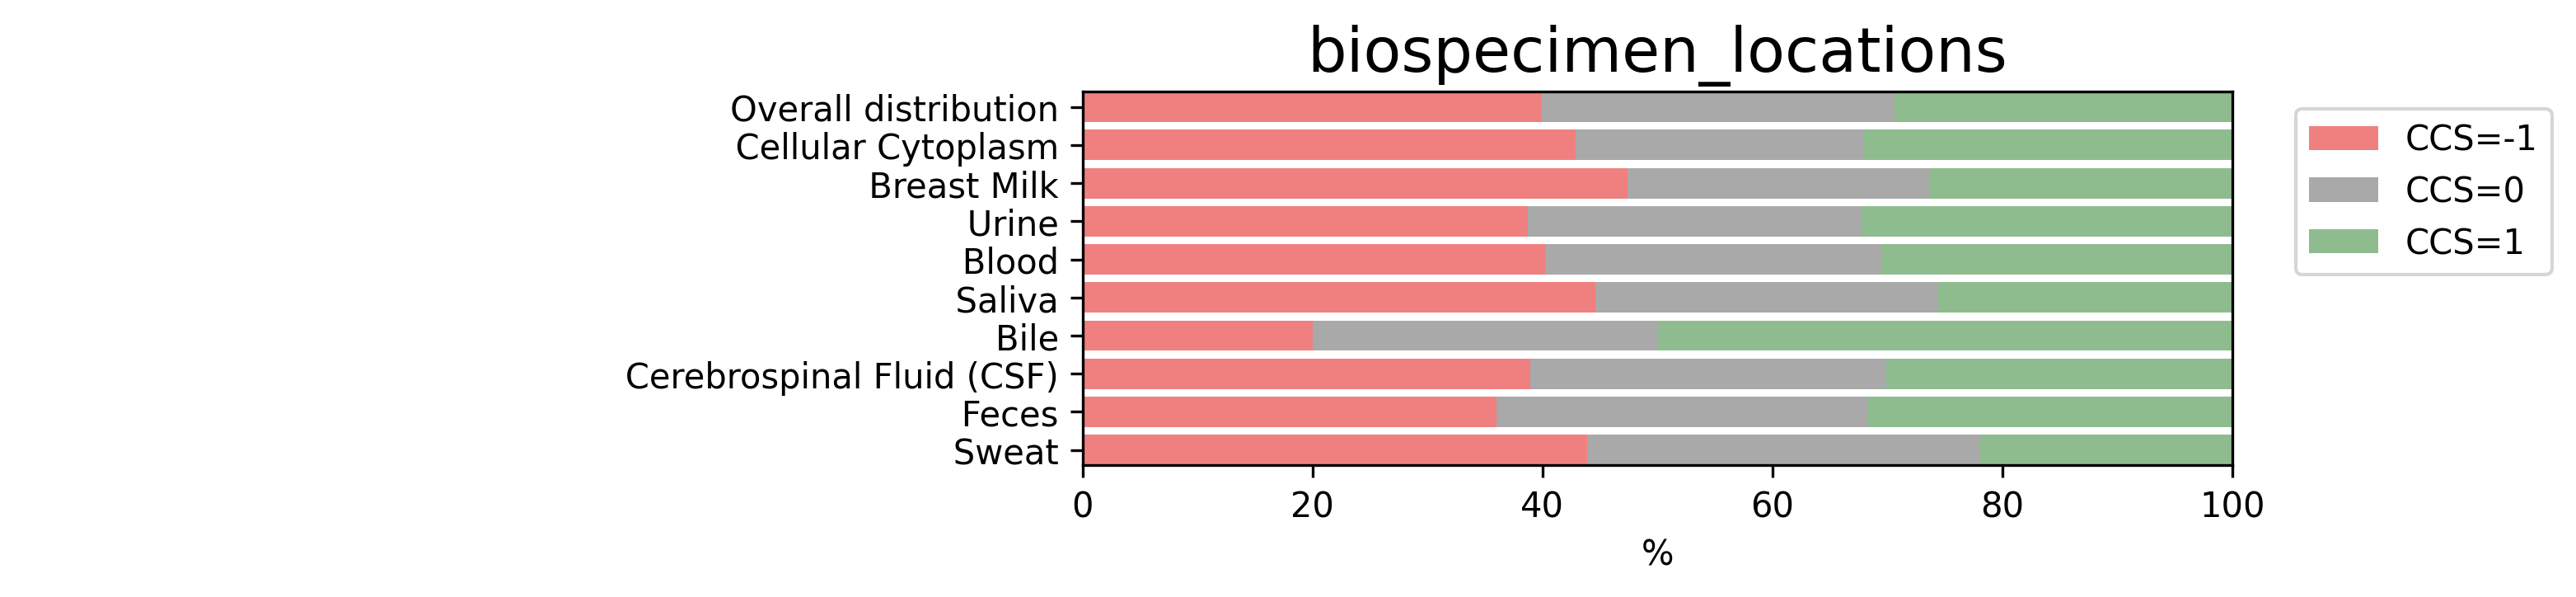

25 bars


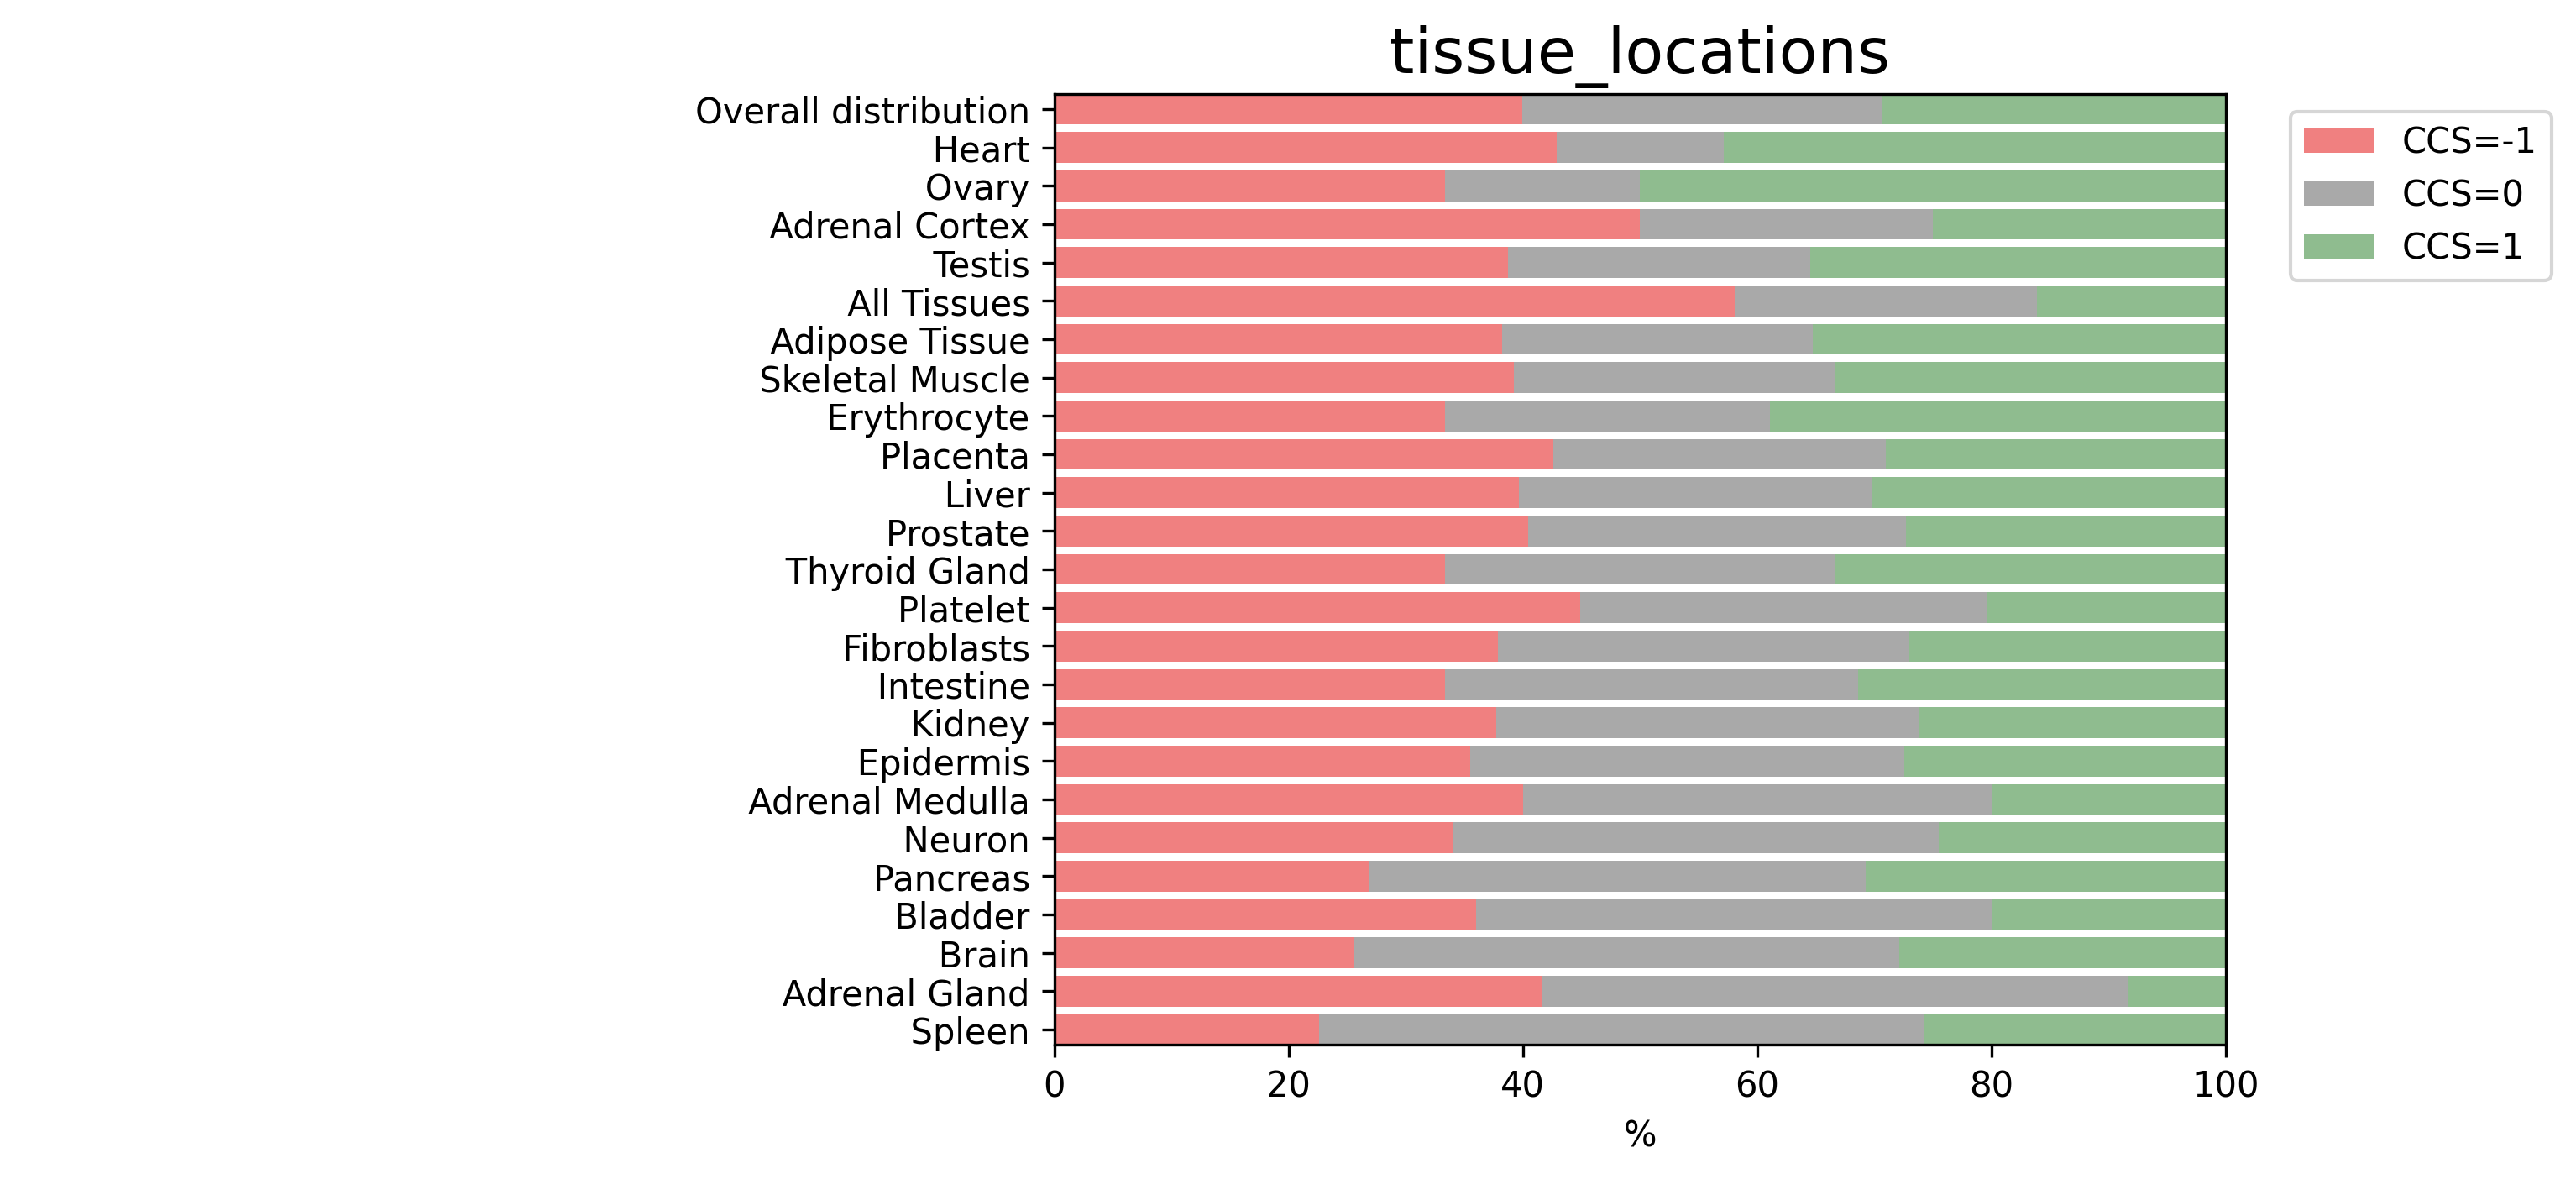

In [10]:
def plot_barh_value_percentages(value_percentages, feature_name, save_fig=False):
    value_percentages = value_percentages.sort_values([0], ascending=False)
#     value_percentages = value_percentages.sort_values([1])
    original_row = f'{"Overall distribution": >80}'
    value_percentages = pd.concat([value_percentages.drop(original_row, axis=0), value_percentages.loc[[original_row],:]], axis=0)
    
    down_values = value_percentages.loc[:, -1].values
    equal_values = value_percentages.loc[:, 0].values
    up_values = value_percentages.loc[:, 1].values
    labels=list(value_percentages.index)

    print(value_percentages.shape[0], 'bars')
    
    fig = plt.figure(figsize=(6, value_percentages.shape[0]/5), dpi=300)
    fig.patch.set_facecolor('white')    
    plt.xlabel('%')
    plt.title(feature_name, fontsize=18)
    plt.margins(0)
    plt.barh(y=labels, width=down_values, label='CCS=-1', color='lightcoral')
    plt.barh(y=labels, width=equal_values, left=down_values, label='CCS=0', color='darkgray')
    plt.barh(y=labels, width=up_values, left=down_values+equal_values, label='CCS=1', color='darkseagreen')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    if save_fig:
        filename = f'barh--{feature_name}.png'
        plt.savefig(Path('figures', filename), bbox_inches='tight')
    plt.show()

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})
    
for feature_name, value_percentages_df in value_percentages_dfs.items():
    plot_barh_value_percentages(value_percentages_df, feature_name, save_fig=True)

In [12]:
def boxplot_CCS_values(dataloader, feature_name, ylabel=False, save_fig=False):
    metabolite_down_mask = dataloader.y.values==-1
    metabolite_equal_mask = dataloader.y.values==0
    metabolite_up_mask = dataloader.y.values==1

    amw = dataloader.X[feature_name]

    fig = plt.figure(figsize=(6,4), dpi=200)
    fig.patch.set_facecolor('white')    

    plt.boxplot([np.array(amw)[metabolite_down_mask], np.array(amw)[metabolite_equal_mask], np.array(amw)[metabolite_up_mask]], labels=[-1, 0, 1])
    fontsize_labels=14
    plt.xlabel('CCS', fontsize=fontsize_labels)
    if not ylabel:
        ylabel = feature_name
    plt.ylabel(ylabel, fontsize=fontsize_labels)
    
    plt.tight_layout()
    if save_fig:
        filename = f'{ylabel}--vs--CCS'
        plt.savefig(Path('Figures', filename))
    plt.show()
    
# boxplot_CCS_values(dataloader,  'average_molecular_weight', 'Average molecular weight (Da)', save_fig=True)
# boxplot_CCS_values(dataloader,  'monisotopic_molecular_weight', 'Monoisotopic molecular weight (Da)')

<a id='Protein_Atrributes'></a>
## 3. Protein attributes

In [15]:
dataloader.protein_features

"Aminopeptidase" in Molecular function  \
Gene                                              
KYNU                                          0   
CNDP1                                         0   
CNDP2                                         0   
GGT1                                          0   
ETNPPL                                        0   
...                                         ...   
HMGCL                                         0   
HMGCLL1                                       0   
OXCT2                                         0   
MS4A7                                         0   
HPD                                           0   

         "Growth factor binding" in Molecular function  \
Gene                                                     
KYNU                                                 0   
CNDP1                                                0   
CNDP2                                                0   
GGT1                                                 0   
ETNPPL                                               0   
...                                                ...   
HMGCL                                                0   
HMGCLL1                                              0   
OXCT2                                                0   
MS4A7                                                0   
HPD                                                  0   

         "Nuclease" in Molecular function  "Lyase" in Molecular function  \
Gene                                                                       
KYNU                                    0                              0   
CNDP1                                   0                              0   
CNDP2                                   0                              0   
GGT1                                    0                              0   
ETNPPL                                  0                              1   
...                                   ...                            ...   
HMGCL                                   0                              1   
HMGCLL1                                 0                              1   
OXCT2                                   0                              0   
MS4A7                                   0                              0   
HPD                                     0                              0   

         "IgG-binding protein" in Molecular function  \
Gene                                                   
KYNU                                               0   
CNDP1                                              0   
CNDP2                                              0   
GGT1                                               0   
ETNPPL                                             0   
...                                              ...   
HMGCL                                              0   
HMGCLL1                                            0   
OXCT2                                              0   
MS4A7                                              0   
HPD                                                0   

         "Serine esterase" in Molecular function  \
Gene                                               
KYNU                                           0   
CNDP1                                          0   
CNDP2                                          0   
GGT1                                           0   
ETNPPL                                         0   
...                                          ...   
HMGCL                                          0   
HMGCLL1                                        0   
OXCT2                                          0   
MS4A7                                          0   
HPD                                            0   

         "Endonuclease" in Molecular function  \
Gene                                            
KYNU                                        0   
CNDP1                                       0   

### Check how many protein feature columns are still included

In [3]:
colnames = pd.Series(list(dataloader.protein_features.columns))
mol_func_bool = pd.Series(['Molecular function' in colname for colname in colnames])
bio_proc_bool = pd.Series(['Biological process' in colname for colname in colnames])
prot_class_bool = pd.Series(['Protein class' in colname for colname in colnames])

print('Columns Molecular function: ', len(colnames[mol_func_bool]), '/ 130')
print('Columns Biological process: ', len(colnames[bio_proc_bool]), '/ 233')
print('Columns Protein class: ', len(colnames[prot_class_bool]), '/ 21')

Columns Molecular function:  112 / 130
Columns Biological process:  188 / 233
Columns Protein class:  21 / 21


### Investigate unmatched proteins

In [6]:
print('UNMATCHED REMOVED PROTEINS')
dataloader.print_protein_names(dataloader.protein_nodes_gene[dataloader.protein_nodes_gene.isna()].index)

UNMATCHED REMOVED PROTEINS
'ABCF2', 'ACOT7L', 'AGAP10', 'AGAP7', 'AHSA2', 'AILE3', 'AKR1C8P', 'AKR7L', 'ALDOA', 'ANKRD26P1', 'ANKRD36BP1', 'ANP32C', 'APOBEC3A_B', 'ARP3BETA', 'ASB16-AS1', 'ATXN7', 'B-RAF', 'BCE1', 'BCR-ABL', 'BCR/ABL', 'C10ORF10', 'C10ORF12', 'C10ORF2', 'C10ORF32', 'C10ORF35', 'C10ORF4', 'C10ORF54', 'C10ORF55', 'C10ORF62', 'C10ORF76', 'C10ORF82', 'C10ORF88', 'C10ORF90', 'C11ORF1', 'C11ORF16', 'C11ORF30', 'C11ORF31', 'C11ORF45', 'C11ORF49', 'C11ORF52', 'C11ORF53', 'C11ORF54', 'C11ORF57', 'C11ORF58', 'C11ORF63', 'C11ORF65', 'C11ORF68', 'C11ORF70', 'C11ORF71', 'C11ORF73', 'C11ORF74', 'C11ORF80', 'C11ORF84', 'C11ORF87', 'C12ORF10', 'C12ORF29', 'C12ORF4', 'C12ORF40', 'C12ORF43', 'C12ORF45', 'C12ORF49', 'C12ORF5', 'C12ORF50', 'C12ORF57', 'C12ORF60', 'C12ORF65', 'C12ORF73', 'C12ORF75', 'C12ORF76', 'C14ORF1', 'C14ORF105', 'C14ORF119', 'C14ORF142', 'C14ORF159', 'C14ORF166', 'C14ORF169', 'C14ORF178', 'C14ORF182', 'C14ORF2', 'C14ORF20', 'C14ORF80', 'C14ORF93', 'C15ORF38-AP3S2', '

<a id='Metabolite_Class_Labels'></a>
## 4. y vector (target class labels)

### Target distribution statistics

In [2]:
dataloader.target_distribution_stats()

### Plot log2fold change values

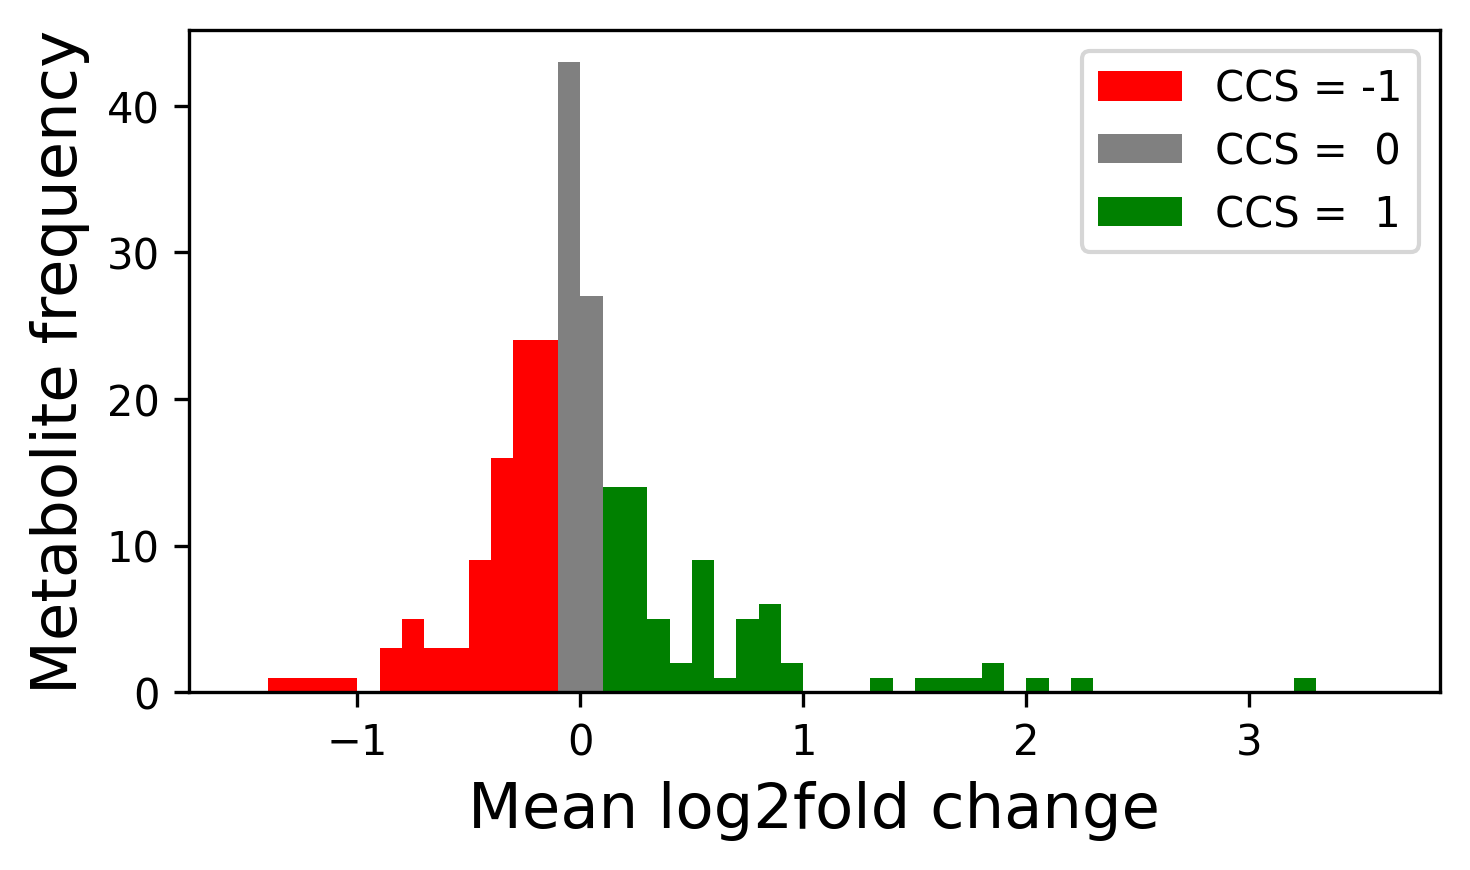

In [4]:
def plot_meanlog2foldchange_histogram(dataloader, save_fig=False):
    fig = plt.figure(figsize=(5,3), dpi=300)
    fig.patch.set_facecolor('white')   
    
    # Get mean log2fold_change based of CCS value
    delta_equal = dataloader.hmdb_log2fold_change_CSS[dataloader.hmdb_log2fold_change_CSS['CCS'] == 0]['log2foldchange']
    delta_up = dataloader.hmdb_log2fold_change_CSS[dataloader.hmdb_log2fold_change_CSS['CCS'] == 1]['log2foldchange']
    delta_down = dataloader.hmdb_log2fold_change_CSS[dataloader.hmdb_log2fold_change_CSS['CCS'] == -1]['log2foldchange']
    
    # Determine equal bin sizes
    xmin = -1.5
    xmax = 3.7
    stepsize = .1
#     total = (xmax-xmin)/stepsize
    bins_down = np.arange(xmin, 0, stepsize)
    bins_equal = np.arange(-0.1, 0.1999, stepsize)
    bins_up = np.arange(0.1, xmax, stepsize)
    bins_all = np.arange(xmin, xmax, stepsize)    
    
    # Plot histogram per CCS category
    plt.hist(delta_down, color='red', bins=bins_down, label='CCS = -1')
    plt.hist(delta_equal, color='gray', bins=bins_equal, label='CCS =  0')
    plt.hist(delta_up, color='green', bins=bins_up, label='CCS =  1')
    plt.legend()
    
    plt.xlabel('Mean log2fold change', fontsize=15)
    plt.ylabel('Metabolite frequency', fontsize=15)
    plt.tight_layout()
    if save_fig:            
        filename = f'sportomics--histogram--log2foldchange.png'
        plt.savefig(Path('figures', filename), bbox_inches='tight')
    plt.show()

plot_meanlog2foldchange_histogram(dataloader, True)

### Test for normality of mean log2fold change values

In [5]:
#Testing for normality of hmdb_log2fold_change_CSS['log2foldchange']
#There is still a single NaN value in the array to be removed

array = dataloader.hmdb_log2fold_change_CSS['log2foldchange'][dataloader.hmdb_log2fold_change_CSS['log2foldchange'].notna()]
normaltest(array, nan_policy='omit')
shapiro(array)

ShapiroResult(statistic=0.8464573621749878, pvalue=3.026792954729379e-14)

### Visualize log2fold change and CCS values

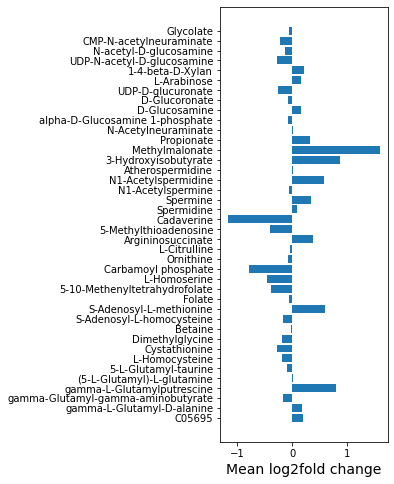

In [4]:
dataloader.millan_2020.plot_changes('Mean log2fold change', from_id=100, till_id=140, save_fig=True)

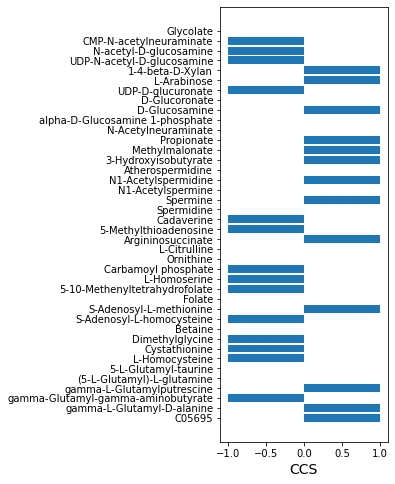

In [5]:
dataloader.millan_2020.plot_changes('CCS', from_id=100, till_id=140, save_fig=True)